In [1]:
import pandas as pd
import json
import ast
import math
from scipy.optimize import minimize_scalar
import numpy as np
from skopt import gp_minimize, dump, load
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

# importing custom model and gridworld code
import sys
sys.path.append('../dual_model/src')
from grid import Grid
from agent import Agent

In [2]:
TEST_GRIDS = {}
with open('../web_experiments/insight_experiment/test_data.json') as json_file:
    grids = json.load(json_file)
    for gridnum, grid in grids.items():
        python_grid = {key: tuple(value) for key, value in grid.items() if key!="best_reward"}
        python_grid['best_reward'] = grid['best_reward']
        python_grid['num1'] = 1
        python_grid['num2'] = 2
        if 300 > int(gridnum) > 100:
            TEST_GRIDS[int(gridnum)] = python_grid

In [3]:
def transform_pos(pos):
    return tuple([4-pos[1],pos[0]])

def preprocess(data):
    preprocessed = pd.read_csv(data)
    preprocessed = preprocessed[(preprocessed['type']=='test') & (preprocessed['step']<6) & (preprocessed['gridnum']<300) & (preprocessed['gridnum']>100)]
    preprocessed = preprocessed[~preprocessed.groupby(['userid', 'trialnum'])['action'].transform(lambda x: x.isnull().any())]
    preprocessed['state'] = preprocessed['state'].apply(ast.literal_eval)
    preprocessed['transformed_state'] = preprocessed.apply(lambda row: (
        transform_pos(row['state']['agent']),
        transform_pos(row['state']['train']),
        transform_pos(row['state']['cargo1']),
        transform_pos(row['state']['cargo2']),
        row['step']
    ), axis=1)
    preprocessed['action'] = preprocessed['action'].map({'x':0, '^':1, '>':2, 'v':3, '<':4} )
    return preprocessed

insight_data = preprocess('data/insight_data_after_exclusions.csv')
time_pressure_data = preprocess('data/time_pressure_data_after_exclusions.csv') 

In [4]:
def softmax(x, temperature):
        x = np.array(x) / temperature
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

def neg_log_likelihood(beta, data, model):
    nll = -np.sum(data.apply(lambda x: math.log(softmax(x[model+'_Q'],beta)[x.action]), axis=1))
    return nll

def minimize_NLL_deterministic(model, data):
    np.random.seed()
    agent=Agent()
    Q_dict = {}
    for gridnum, grid in TEST_GRIDS.items():
        grid = Grid(init_pos=grid)
        Q_dict[gridnum] = agent.mc_first_visit_control(grid, iters=0, nn_init=True, compute_full_Q_dict=True)
    data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)
    beta = minimize_scalar(lambda beta: neg_log_likelihood(beta, data, model),bounds=(0.01, 10), method='bounded').x
    return beta, neg_log_likelihood(beta, data, model)

def calculate_NLL_stochastic(x, model, data):
    beta = x[0] 
    iters = x[1]
    agent=Agent()
    Q_dict = {}
    for gridnum, grid in TEST_GRIDS.items():
        grid = Grid(init_pos=grid)
        if model == 'MC':
            Q_dict[gridnum] = agent.mc_first_visit_control(grid, iters=iters, nn_init=False)
        if model == 'dual':
            Q_dict[gridnum] = agent.mc_first_visit_control(grid, iters=iters, nn_init=True, compute_full_Q_dict=True)
    data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)
    nll = neg_log_likelihood(beta, data, model)
    return nll

def calculate_BIC(nll, data, free_params):
    return free_params * math.log(len(data)) + 2 * nll

In [14]:
res = gp_minimize(lambda x: calculate_NLL_stochastic(x, model="MC",data=insight_data),                  # the function to minimize
                  [(0.1, 1), (0,50000)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=100,         # the number of evaluations of f
                  n_initial_points=10,  # the number of random initialization points
                  random_state=1234,   # the random seed
                  verbose=True)   
res.specs['args']['func'] = None
dump(res, 'model_fitting/mc_optimize.pkl')

Iteration No: 1 started. Evaluating function at random point.


KeyboardInterrupt: 

In [21]:
res = gp_minimize(lambda x: calculate_NLL_stochastic(x, model="dual",data=insight_data),                  # the function to minimize
                  [(0.1, 1), (0,50000)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=100,         # the number of evaluations of f
                  n_initial_points=10,  # the number of random initialization points
                  random_state=1234,   # the random seed
                  verbose=True)   
res.specs['args']['func'] = None
dump(res, 'model_fitting/dual_optimize.pkl')

Iteration No: 1 started. Evaluating function at random point.
0.5478972998253845 42714 26583.59740070767
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 489.7268
Function value obtained: 26583.5974
Current minimum: 26583.5974
Iteration No: 2 started. Evaluating function at random point.
0.6509007052095438 40854 27314.380550855523
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 353.5929
Function value obtained: 27314.3806
Current minimum: 26583.5974
Iteration No: 3 started. Evaluating function at random point.
0.8746027942399187 16025 28488.629742206605
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 160.3222
Function value obtained: 28488.6297
Current minimum: 26583.5974
Iteration No: 4 started. Evaluating function at random point.
0.2786668831235539 42607 24064.96110695771
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 570.1646
Function value obtained: 24064.9611
Current minimum: 24064.9611
Iteration No: 

In [59]:
nn_beta, nn_nll = minimize_NLL_deterministic("NN", insight_data)

In [ ]:
dual_res = load('model_fitting/dual_optimize.pkl')
mc_res = load('model_fitting/mc_optimize.pkl')

AttributeError: Can't get attribute 'calculate_NLL' on <module '__main__'>

In [10]:
dual_bic = calculate_BIC(dual_res.fun, insight_data, free_params=2)
mc_bic = calculate_BIC(mc_res.fun, insight_data, free_params=2)
nn_bic = calculate_BIC(nn_nll, insight_data, free_params=1)

print("Dual Model")
print("Iters: ", dual_res.x[1], "| Beta: ", np.round(dual_res.x[0],2), "| NLL: ", np.round(dual_res.fun,2), "| BIC: ", np.round(dual_bic,2))
print("MC Model")
print("Iters: ", mc_res.x[1], "| Beta: ", np.round(mc_res.x[0],2), "| NLL: ", np.round(mc_res.fun,2), "| BIC: ", np.round(mc_bic,2))
print("NN Model")
print("Beta: ", np.round(nn_beta,2), "| NLL: ", np.round(nn_nll,2), "| BIC: ", np.round(nn_bic,2))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_convergence(dual_res, ax=ax[0])
ax[0].set_title('Dual Model Convergence')

plot_convergence(mc_res, ax=ax[1])
ax[1].set_title('MC Model Convergence')

plt.tight_layout()
plt.show()

NameError: name 'nn_nll' is not defined

In [7]:
time_delay = time_pressure_data[time_pressure_data['timed'] == 0]
time_pressure = time_pressure_data[time_pressure_data['timed'] == 1]

time_separate = gp_minimize(lambda x: calculate_NLL_stochastic([x[0],x[1]], model="dual",data=time_delay) + calculate_NLL_stochastic([x[0],x[2]], model="dual",data=time_pressure),                  # the function to minimize
                  [(0.1, 5), (0,5000), (0,5000)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=1000,         # the number of evaluations of f
                  n_initial_points=100,  # the number of random initialization points
                  random_state=1234,   # the random seed
                  verbose=True)   
time_separate.specs['args']['func'] = None
dump(time_separate, 'model_fitting/time_separate_optimize.pkl')

Iteration No: 1 started. Evaluating function at random point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)
/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 98.1140
Function value obtained: 13048.7179
Current minimum: 13048.7179
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 94.2401
Function value obtained: 13189.5466
Current minimum: 13048.7179
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 69.3776
Function value obtained: 13083.6490
Current minimum: 13048.7179
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 71.5473
Function value obtained: 13114.4408
Current minimum: 13048.7179
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 27.0311
Function value obtained: 13061.2039
Current minimum: 13048.7179
Iteration No: 6 started. Evaluating function at rand

/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 49.4409
Function value obtained: 13137.4763
Current minimum: 13014.7061
Iteration No: 122 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 40.0977
Function value obtained: 13059.9010
Current minimum: 13014.7061
Iteration No: 123 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 74.8174
Function value obtained: 13115.9387
Current minimum: 13014.7061
Iteration No: 124 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 54.5658
Function value obtained: 13075.7976
Current minimum: 13014.7061
Iteration No: 125 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 53.8383
Function value obtained: 13072.0150
Current minimum: 13014.7061
Iteration No: 126 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 18.2966
Function value obtained: 13130.8739
Current minimum: 13014.7061
Iteration No: 127 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 39.6040
Function value obtained: 13387.2095
Current minimum: 13014.7061
Iteration No: 128 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 81.5590
Function value obtained: 13111.6131
Current minimum: 13014.7061
Iteration No: 129 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 55.6121
Function value obtained: 13139.1488
Current minimum: 13014.7061
Iteration No: 130 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 78.5793
Function value obtained: 13062.1001
Current minimum: 13014.7061
Iteration No: 131 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 79.7972
Function value obtained: 13098.3300
Current minimum: 13014.7061
Iteration No: 132 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 79.9500
Function value obtained: 13100.2669
Current minimum: 13014.7061
Iteration No: 133 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 48.1928
Function value obtained: 13136.1811
Current minimum: 13014.7061
Iteration No: 134 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 54.8798
Function value obtained: 13093.9291
Current minimum: 13014.7061
Iteration No: 135 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 61.9433
Function value obtained: 13137.5888
Current minimum: 13014.7061
Iteration No: 136 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 19.2345
Function value obtained: 13124.7115
Current minimum: 13014.7061
Iteration No: 137 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 52.9264
Function value obtained: 13089.3529
Current minimum: 13014.7061
Iteration No: 138 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 77.6802
Function value obtained: 13092.4784
Current minimum: 13014.7061
Iteration No: 139 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 43.6607
Function value obtained: 13211.5091
Current minimum: 13014.7061
Iteration No: 140 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 60.9658
Function value obtained: 13052.8070
Current minimum: 13014.7061
Iteration No: 141 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 61.6137
Function value obtained: 13117.7295
Current minimum: 13014.7061
Iteration No: 142 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 53.1390
Function value obtained: 13110.6512
Current minimum: 13014.7061
Iteration No: 143 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 76.2172
Function value obtained: 13100.0513
Current minimum: 13014.7061
Iteration No: 144 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 56.5269
Function value obtained: 13094.8249
Current minimum: 13014.7061
Iteration No: 145 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 17.1263
Function value obtained: 13249.2421
Current minimum: 13014.7061
Iteration No: 146 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 61.4010
Function value obtained: 13096.3507
Current minimum: 13014.7061
Iteration No: 147 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 75.7338
Function value obtained: 13060.4537
Current minimum: 13014.7061
Iteration No: 148 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 76.7865
Function value obtained: 13115.4799
Current minimum: 13014.7061
Iteration No: 149 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 59.6979
Function value obtained: 13087.8128
Current minimum: 13014.7061
Iteration No: 150 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 62.1179
Function value obtained: 13131.7658
Current minimum: 13014.7061
Iteration No: 151 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 69.9899
Function value obtained: 13097.3769
Current minimum: 13014.7061
Iteration No: 152 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 52.0758
Function value obtained: 13091.9716
Current minimum: 13014.7061
Iteration No: 153 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 57.8342
Function value obtained: 13079.5195
Current minimum: 13014.7061
Iteration No: 154 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 75.4773
Function value obtained: 13098.2517
Current minimum: 13014.7061
Iteration No: 155 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 58.2309
Function value obtained: 13078.8752
Current minimum: 13014.7061
Iteration No: 156 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 68.9613
Function value obtained: 13089.6702
Current minimum: 13014.7061
Iteration No: 157 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 54.3956
Function value obtained: 13084.0737
Current minimum: 13014.7061
Iteration No: 158 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 76.6617
Function value obtained: 13078.2396
Current minimum: 13014.7061
Iteration No: 159 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 80.1272
Function value obtained: 13109.1416
Current minimum: 13014.7061
Iteration No: 160 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 60.6439
Function value obtained: 13108.5578
Current minimum: 13014.7061
Iteration No: 161 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 73.6652
Function value obtained: 13113.2285
Current minimum: 13014.7061
Iteration No: 162 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 57.0447
Function value obtained: 13077.9173
Current minimum: 13014.7061
Iteration No: 163 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 52.5285
Function value obtained: 13147.0563
Current minimum: 13014.7061
Iteration No: 164 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 77.7563
Function value obtained: 13087.5530
Current minimum: 13014.7061
Iteration No: 165 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 69.5530
Function value obtained: 13107.4346
Current minimum: 13014.7061
Iteration No: 166 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 80.6246
Function value obtained: 13087.7452
Current minimum: 13014.7061
Iteration No: 167 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 63.7090
Function value obtained: 13083.7943
Current minimum: 13014.7061
Iteration No: 168 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 57.8734
Function value obtained: 13120.4148
Current minimum: 13014.7061
Iteration No: 169 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 77.9107
Function value obtained: 13146.1199
Current minimum: 13014.7061
Iteration No: 170 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 63.2319
Function value obtained: 13133.0027
Current minimum: 13014.7061
Iteration No: 171 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 70.2762
Function value obtained: 13097.4907
Current minimum: 13014.7061
Iteration No: 172 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 20.0258
Function value obtained: 13225.4634
Current minimum: 13014.7061
Iteration No: 173 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 51.3735
Function value obtained: 13088.3029
Current minimum: 13014.7061
Iteration No: 174 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 74.0319
Function value obtained: 13069.7428
Current minimum: 13014.7061
Iteration No: 175 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 74.7486
Function value obtained: 13100.9755
Current minimum: 13014.7061
Iteration No: 176 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 80.4319
Function value obtained: 13100.5608
Current minimum: 13014.7061
Iteration No: 177 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 59.9413
Function value obtained: 13093.1021
Current minimum: 13014.7061
Iteration No: 178 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 70.4323
Function value obtained: 13109.6146
Current minimum: 13014.7061
Iteration No: 179 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 65.5376
Function value obtained: 13114.8674
Current minimum: 13014.7061
Iteration No: 180 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 51.8623
Function value obtained: 13096.5824
Current minimum: 13014.7061
Iteration No: 181 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 80.3723
Function value obtained: 13077.4254
Current minimum: 13014.7061
Iteration No: 182 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 77.7140
Function value obtained: 13073.5513
Current minimum: 13014.7061
Iteration No: 183 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 79.9607
Function value obtained: 13080.7743
Current minimum: 13014.7061
Iteration No: 184 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 76.0077
Function value obtained: 13071.9783
Current minimum: 13014.7061
Iteration No: 185 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 61.8614
Function value obtained: 13144.2838
Current minimum: 13014.7061
Iteration No: 186 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 85.1392
Function value obtained: 13098.3182
Current minimum: 13014.7061
Iteration No: 187 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 78.1607
Function value obtained: 13105.7699
Current minimum: 13014.7061
Iteration No: 188 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 51.8312
Function value obtained: 13106.6700
Current minimum: 13014.7061
Iteration No: 189 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 73.4148
Function value obtained: 13105.3293
Current minimum: 13014.7061
Iteration No: 190 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 69.9465
Function value obtained: 13077.2442
Current minimum: 13014.7061
Iteration No: 191 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 65.9416
Function value obtained: 13093.2273
Current minimum: 13014.7061
Iteration No: 192 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 31.9899
Function value obtained: 13089.4758
Current minimum: 13014.7061
Iteration No: 193 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 81.5969
Function value obtained: 13081.6959
Current minimum: 13014.7061
Iteration No: 194 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 27.5140
Function value obtained: 13354.0473
Current minimum: 13014.7061
Iteration No: 195 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 47.1241
Function value obtained: 13102.3253
Current minimum: 13014.7061
Iteration No: 196 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 37.2614
Function value obtained: 13075.2671
Current minimum: 13014.7061
Iteration No: 197 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 33.4048
Function value obtained: 13069.7774
Current minimum: 13014.7061
Iteration No: 198 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 28.3045
Function value obtained: 13070.3648
Current minimum: 13014.7061
Iteration No: 199 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 51.0312
Function value obtained: 13086.4922
Current minimum: 13014.7061
Iteration No: 200 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 57.6560
Function value obtained: 13093.1836
Current minimum: 13014.7061
Iteration No: 201 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 201 ended. Search finished for the next optimal point.
Time taken: 67.0250
Function value obtained: 13084.1317
Current minimum: 13014.7061
Iteration No: 202 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 202 ended. Search finished for the next optimal point.
Time taken: 41.7631
Function value obtained: 13104.6551
Current minimum: 13014.7061
Iteration No: 203 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 203 ended. Search finished for the next optimal point.
Time taken: 62.9877
Function value obtained: 13099.1811
Current minimum: 13014.7061
Iteration No: 204 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 32.9034
Function value obtained: 13099.6686
Current minimum: 13014.7061
Iteration No: 205 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 33.7323
Function value obtained: 13087.0919
Current minimum: 13014.7061
Iteration No: 206 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 206 ended. Search finished for the next optimal point.
Time taken: 30.6031
Function value obtained: 13070.4646
Current minimum: 13014.7061
Iteration No: 207 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 33.1558
Function value obtained: 13090.6745
Current minimum: 13014.7061
Iteration No: 208 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 39.1339
Function value obtained: 13080.3088
Current minimum: 13014.7061
Iteration No: 209 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 50.5093
Function value obtained: 13113.3829
Current minimum: 13014.7061
Iteration No: 210 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 64.7935
Function value obtained: 13065.6907
Current minimum: 13014.7061
Iteration No: 211 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 29.2832
Function value obtained: 13165.3139
Current minimum: 13014.7061
Iteration No: 212 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 212 ended. Search finished for the next optimal point.
Time taken: 50.2183
Function value obtained: 13136.0337
Current minimum: 13014.7061
Iteration No: 213 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 55.6160
Function value obtained: 13055.4190
Current minimum: 13014.7061
Iteration No: 214 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 69.4687
Function value obtained: 13104.3036
Current minimum: 13014.7061
Iteration No: 215 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 215 ended. Search finished for the next optimal point.
Time taken: 38.3732
Function value obtained: 13094.4155
Current minimum: 13014.7061
Iteration No: 216 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 25.3216
Function value obtained: 13113.2700
Current minimum: 13014.7061
Iteration No: 217 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 56.0583
Function value obtained: 13087.9945
Current minimum: 13014.7061
Iteration No: 218 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 53.8776
Function value obtained: 13094.9942
Current minimum: 13014.7061
Iteration No: 219 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 50.6805
Function value obtained: 13124.3069
Current minimum: 13014.7061
Iteration No: 220 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 62.7733
Function value obtained: 13084.2648
Current minimum: 13014.7061
Iteration No: 221 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 55.4955
Function value obtained: 13156.9957
Current minimum: 13014.7061
Iteration No: 222 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 222 ended. Search finished for the next optimal point.
Time taken: 53.2809
Function value obtained: 13081.7527
Current minimum: 13014.7061
Iteration No: 223 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 223 ended. Search finished for the next optimal point.
Time taken: 64.5258
Function value obtained: 13069.2888
Current minimum: 13014.7061
Iteration No: 224 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 224 ended. Search finished for the next optimal point.
Time taken: 23.8092
Function value obtained: 13071.5413
Current minimum: 13014.7061
Iteration No: 225 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 225 ended. Search finished for the next optimal point.
Time taken: 59.6811
Function value obtained: 13095.9674
Current minimum: 13014.7061
Iteration No: 226 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 226 ended. Search finished for the next optimal point.
Time taken: 32.5406
Function value obtained: 13111.6569
Current minimum: 13014.7061
Iteration No: 227 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 227 ended. Search finished for the next optimal point.
Time taken: 39.1305
Function value obtained: 13102.2887
Current minimum: 13014.7061
Iteration No: 228 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 228 ended. Search finished for the next optimal point.
Time taken: 54.2972
Function value obtained: 13101.9615
Current minimum: 13014.7061
Iteration No: 229 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 229 ended. Search finished for the next optimal point.
Time taken: 65.9309
Function value obtained: 13091.2850
Current minimum: 13014.7061
Iteration No: 230 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 230 ended. Search finished for the next optimal point.
Time taken: 58.2239
Function value obtained: 13133.5800
Current minimum: 13014.7061
Iteration No: 231 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 231 ended. Search finished for the next optimal point.
Time taken: 48.4341
Function value obtained: 13078.3058
Current minimum: 13014.7061
Iteration No: 232 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 232 ended. Search finished for the next optimal point.
Time taken: 26.2362
Function value obtained: 13056.2606
Current minimum: 13014.7061
Iteration No: 233 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 24.2952
Function value obtained: 13129.7397
Current minimum: 13014.7061
Iteration No: 234 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 234 ended. Search finished for the next optimal point.
Time taken: 31.8294
Function value obtained: 13110.7109
Current minimum: 13014.7061
Iteration No: 235 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 235 ended. Search finished for the next optimal point.
Time taken: 64.8903
Function value obtained: 13115.1385
Current minimum: 13014.7061
Iteration No: 236 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 236 ended. Search finished for the next optimal point.
Time taken: 44.4503
Function value obtained: 13094.2363
Current minimum: 13014.7061
Iteration No: 237 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 58.4534
Function value obtained: 13087.8063
Current minimum: 13014.7061
Iteration No: 238 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 46.0616
Function value obtained: 13075.2575
Current minimum: 13014.7061
Iteration No: 239 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 239 ended. Search finished for the next optimal point.
Time taken: 46.8323
Function value obtained: 13126.0957
Current minimum: 13014.7061
Iteration No: 240 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 240 ended. Search finished for the next optimal point.
Time taken: 50.8468
Function value obtained: 13079.6893
Current minimum: 13014.7061
Iteration No: 241 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 241 ended. Search finished for the next optimal point.
Time taken: 64.6987
Function value obtained: 13134.9288
Current minimum: 13014.7061
Iteration No: 242 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 242 ended. Search finished for the next optimal point.
Time taken: 41.1705
Function value obtained: 13132.3613
Current minimum: 13014.7061
Iteration No: 243 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 77.3536
Function value obtained: 13113.5430
Current minimum: 13014.7061
Iteration No: 244 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 32.7053
Function value obtained: 13143.1891
Current minimum: 13014.7061
Iteration No: 245 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 41.6738
Function value obtained: 13048.7943
Current minimum: 13014.7061
Iteration No: 246 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 41.1583
Function value obtained: 13104.4541
Current minimum: 13014.7061
Iteration No: 247 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 247 ended. Search finished for the next optimal point.
Time taken: 48.7040
Function value obtained: 13115.5377
Current minimum: 13014.7061
Iteration No: 248 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 35.9665
Function value obtained: 13087.7643
Current minimum: 13014.7061
Iteration No: 249 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 52.3359
Function value obtained: 13088.1401
Current minimum: 13014.7061
Iteration No: 250 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 55.0532
Function value obtained: 13050.8927
Current minimum: 13014.7061
Iteration No: 251 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 251 ended. Search finished for the next optimal point.
Time taken: 48.1046
Function value obtained: 13099.8802
Current minimum: 13014.7061
Iteration No: 252 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 252 ended. Search finished for the next optimal point.
Time taken: 71.3926
Function value obtained: 13117.7114
Current minimum: 13014.7061
Iteration No: 253 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 253 ended. Search finished for the next optimal point.
Time taken: 55.4451
Function value obtained: 13165.6776
Current minimum: 13014.7061
Iteration No: 254 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 254 ended. Search finished for the next optimal point.
Time taken: 49.5229
Function value obtained: 13076.0258
Current minimum: 13014.7061
Iteration No: 255 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 255 ended. Search finished for the next optimal point.
Time taken: 61.7422
Function value obtained: 13095.7229
Current minimum: 13014.7061
Iteration No: 256 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 256 ended. Search finished for the next optimal point.
Time taken: 28.1076
Function value obtained: 13081.3997
Current minimum: 13014.7061
Iteration No: 257 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 257 ended. Search finished for the next optimal point.
Time taken: 54.6403
Function value obtained: 13102.3601
Current minimum: 13014.7061
Iteration No: 258 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 258 ended. Search finished for the next optimal point.
Time taken: 53.3629
Function value obtained: 13083.7484
Current minimum: 13014.7061
Iteration No: 259 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 259 ended. Search finished for the next optimal point.
Time taken: 55.6869
Function value obtained: 13097.0868
Current minimum: 13014.7061
Iteration No: 260 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 260 ended. Search finished for the next optimal point.
Time taken: 41.1596
Function value obtained: 13052.7681
Current minimum: 13014.7061
Iteration No: 261 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 261 ended. Search finished for the next optimal point.
Time taken: 40.5265
Function value obtained: 13055.2071
Current minimum: 13014.7061
Iteration No: 262 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 262 ended. Search finished for the next optimal point.
Time taken: 44.0111
Function value obtained: 13097.3984
Current minimum: 13014.7061
Iteration No: 263 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 263 ended. Search finished for the next optimal point.
Time taken: 40.6368
Function value obtained: 13117.2253
Current minimum: 13014.7061
Iteration No: 264 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 264 ended. Search finished for the next optimal point.
Time taken: 65.5476
Function value obtained: 13118.1046
Current minimum: 13014.7061
Iteration No: 265 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 265 ended. Search finished for the next optimal point.
Time taken: 38.6528
Function value obtained: 13128.5535
Current minimum: 13014.7061
Iteration No: 266 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 266 ended. Search finished for the next optimal point.
Time taken: 24.9922
Function value obtained: 13043.2895
Current minimum: 13014.7061
Iteration No: 267 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 267 ended. Search finished for the next optimal point.
Time taken: 25.3881
Function value obtained: 13048.6581
Current minimum: 13014.7061
Iteration No: 268 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 268 ended. Search finished for the next optimal point.
Time taken: 25.2304
Function value obtained: 13140.7943
Current minimum: 13014.7061
Iteration No: 269 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 269 ended. Search finished for the next optimal point.
Time taken: 56.2256
Function value obtained: 13099.8563
Current minimum: 13014.7061
Iteration No: 270 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 270 ended. Search finished for the next optimal point.
Time taken: 33.9620
Function value obtained: 13110.7038
Current minimum: 13014.7061
Iteration No: 271 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 271 ended. Search finished for the next optimal point.
Time taken: 52.6253
Function value obtained: 13061.1053
Current minimum: 13014.7061
Iteration No: 272 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 272 ended. Search finished for the next optimal point.
Time taken: 48.4380
Function value obtained: 13090.4435
Current minimum: 13014.7061
Iteration No: 273 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 273 ended. Search finished for the next optimal point.
Time taken: 47.4629
Function value obtained: 13082.1012
Current minimum: 13014.7061
Iteration No: 274 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 274 ended. Search finished for the next optimal point.
Time taken: 36.4938
Function value obtained: 13210.5988
Current minimum: 13014.7061
Iteration No: 275 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 275 ended. Search finished for the next optimal point.
Time taken: 25.9731
Function value obtained: 13062.7913
Current minimum: 13014.7061
Iteration No: 276 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 276 ended. Search finished for the next optimal point.
Time taken: 68.2823
Function value obtained: 13098.9581
Current minimum: 13014.7061
Iteration No: 277 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 277 ended. Search finished for the next optimal point.
Time taken: 27.0906
Function value obtained: 13100.5695
Current minimum: 13014.7061
Iteration No: 278 started. Searching for the next optimal point.


/opt/miniconda3/envs/reval/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5000, 1222] before, using random point [108, 4020]
  warnings.warn(
/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 278 ended. Search finished for the next optimal point.
Time taken: 39.5845
Function value obtained: 13458.5510
Current minimum: 13014.7061
Iteration No: 279 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 58.4423
Function value obtained: 13114.4161
Current minimum: 13014.7061
Iteration No: 280 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 49.1913
Function value obtained: 13144.0699
Current minimum: 13014.7061
Iteration No: 281 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 281 ended. Search finished for the next optimal point.
Time taken: 69.1044
Function value obtained: 13140.2531
Current minimum: 13014.7061
Iteration No: 282 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 282 ended. Search finished for the next optimal point.
Time taken: 76.2587
Function value obtained: 13071.4178
Current minimum: 13014.7061
Iteration No: 283 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 283 ended. Search finished for the next optimal point.
Time taken: 47.6191
Function value obtained: 13074.3323
Current minimum: 13014.7061
Iteration No: 284 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 284 ended. Search finished for the next optimal point.
Time taken: 34.0265
Function value obtained: 13149.6324
Current minimum: 13014.7061
Iteration No: 285 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 285 ended. Search finished for the next optimal point.
Time taken: 48.0925
Function value obtained: 13097.9481
Current minimum: 13014.7061
Iteration No: 286 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 286 ended. Search finished for the next optimal point.
Time taken: 55.9951
Function value obtained: 13093.7462
Current minimum: 13014.7061
Iteration No: 287 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 287 ended. Search finished for the next optimal point.
Time taken: 74.3749
Function value obtained: 13116.6877
Current minimum: 13014.7061
Iteration No: 288 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 288 ended. Search finished for the next optimal point.
Time taken: 51.5342
Function value obtained: 13082.1511
Current minimum: 13014.7061
Iteration No: 289 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 289 ended. Search finished for the next optimal point.
Time taken: 47.0463
Function value obtained: 13079.9741
Current minimum: 13014.7061
Iteration No: 290 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 290 ended. Search finished for the next optimal point.
Time taken: 36.0745
Function value obtained: 13414.1285
Current minimum: 13014.7061
Iteration No: 291 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 291 ended. Search finished for the next optimal point.
Time taken: 49.3142
Function value obtained: 13095.3998
Current minimum: 13014.7061
Iteration No: 292 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 292 ended. Search finished for the next optimal point.
Time taken: 75.0629
Function value obtained: 13088.6289
Current minimum: 13014.7061
Iteration No: 293 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 293 ended. Search finished for the next optimal point.
Time taken: 57.3077
Function value obtained: 13068.4950
Current minimum: 13014.7061
Iteration No: 294 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 294 ended. Search finished for the next optimal point.
Time taken: 27.2628
Function value obtained: 13126.5482
Current minimum: 13014.7061
Iteration No: 295 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 295 ended. Search finished for the next optimal point.
Time taken: 41.3263
Function value obtained: 13041.9721
Current minimum: 13014.7061
Iteration No: 296 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 296 ended. Search finished for the next optimal point.
Time taken: 40.7151
Function value obtained: 13094.4037
Current minimum: 13014.7061
Iteration No: 297 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 297 ended. Search finished for the next optimal point.
Time taken: 64.8535
Function value obtained: 13096.5717
Current minimum: 13014.7061
Iteration No: 298 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 298 ended. Search finished for the next optimal point.
Time taken: 56.1925
Function value obtained: 13099.4264
Current minimum: 13014.7061
Iteration No: 299 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 299 ended. Search finished for the next optimal point.
Time taken: 76.6928
Function value obtained: 13094.1976
Current minimum: 13014.7061
Iteration No: 300 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 300 ended. Search finished for the next optimal point.
Time taken: 49.4352
Function value obtained: 13127.3458
Current minimum: 13014.7061
Iteration No: 301 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 301 ended. Search finished for the next optimal point.
Time taken: 41.3782
Function value obtained: 13101.7979
Current minimum: 13014.7061
Iteration No: 302 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 302 ended. Search finished for the next optimal point.
Time taken: 70.9176
Function value obtained: 13095.0439
Current minimum: 13014.7061
Iteration No: 303 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 303 ended. Search finished for the next optimal point.
Time taken: 47.2452
Function value obtained: 13109.7193
Current minimum: 13014.7061
Iteration No: 304 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 304 ended. Search finished for the next optimal point.
Time taken: 54.8955
Function value obtained: 13084.7420
Current minimum: 13014.7061
Iteration No: 305 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 305 ended. Search finished for the next optimal point.
Time taken: 63.1266
Function value obtained: 13090.0722
Current minimum: 13014.7061
Iteration No: 306 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 306 ended. Search finished for the next optimal point.
Time taken: 27.4037
Function value obtained: 13070.6110
Current minimum: 13014.7061
Iteration No: 307 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 307 ended. Search finished for the next optimal point.
Time taken: 38.9239
Function value obtained: 13139.8876
Current minimum: 13014.7061
Iteration No: 308 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 308 ended. Search finished for the next optimal point.
Time taken: 77.6972
Function value obtained: 13107.2290
Current minimum: 13014.7061
Iteration No: 309 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 309 ended. Search finished for the next optimal point.
Time taken: 48.2429
Function value obtained: 13078.3844
Current minimum: 13014.7061
Iteration No: 310 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 310 ended. Search finished for the next optimal point.
Time taken: 49.0855
Function value obtained: 13044.9393
Current minimum: 13014.7061
Iteration No: 311 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 311 ended. Search finished for the next optimal point.
Time taken: 48.8983
Function value obtained: 13039.3474
Current minimum: 13014.7061
Iteration No: 312 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 312 ended. Search finished for the next optimal point.
Time taken: 48.4332
Function value obtained: 13100.7396
Current minimum: 13014.7061
Iteration No: 313 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 313 ended. Search finished for the next optimal point.
Time taken: 68.9466
Function value obtained: 13118.1022
Current minimum: 13014.7061
Iteration No: 314 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 314 ended. Search finished for the next optimal point.
Time taken: 27.7132
Function value obtained: 13081.8679
Current minimum: 13014.7061
Iteration No: 315 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 315 ended. Search finished for the next optimal point.
Time taken: 52.4748
Function value obtained: 13091.0531
Current minimum: 13014.7061
Iteration No: 316 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 316 ended. Search finished for the next optimal point.
Time taken: 47.7285
Function value obtained: 13625.4812
Current minimum: 13014.7061
Iteration No: 317 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 317 ended. Search finished for the next optimal point.
Time taken: 50.5787
Function value obtained: 13107.4640
Current minimum: 13014.7061
Iteration No: 318 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 318 ended. Search finished for the next optimal point.
Time taken: 44.9862
Function value obtained: 13106.6593
Current minimum: 13014.7061
Iteration No: 319 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 319 ended. Search finished for the next optimal point.
Time taken: 52.3649
Function value obtained: 13118.6982
Current minimum: 13014.7061
Iteration No: 320 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 320 ended. Search finished for the next optimal point.
Time taken: 72.4131
Function value obtained: 13116.3681
Current minimum: 13014.7061
Iteration No: 321 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 321 ended. Search finished for the next optimal point.
Time taken: 25.7693
Function value obtained: 13047.9171
Current minimum: 13014.7061
Iteration No: 322 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 322 ended. Search finished for the next optimal point.
Time taken: 25.1222
Function value obtained: 13273.6559
Current minimum: 13014.7061
Iteration No: 323 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 323 ended. Search finished for the next optimal point.
Time taken: 48.6071
Function value obtained: 13078.1841
Current minimum: 13014.7061
Iteration No: 324 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 324 ended. Search finished for the next optimal point.
Time taken: 51.6483
Function value obtained: 13083.4824
Current minimum: 13014.7061
Iteration No: 325 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 325 ended. Search finished for the next optimal point.
Time taken: 32.6105
Function value obtained: 13100.6902
Current minimum: 13014.7061
Iteration No: 326 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 326 ended. Search finished for the next optimal point.
Time taken: 55.4528
Function value obtained: 13058.2150
Current minimum: 13014.7061
Iteration No: 327 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 327 ended. Search finished for the next optimal point.
Time taken: 49.2452
Function value obtained: 13138.5786
Current minimum: 13014.7061
Iteration No: 328 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 328 ended. Search finished for the next optimal point.
Time taken: 48.6487
Function value obtained: 13068.7708
Current minimum: 13014.7061
Iteration No: 329 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 329 ended. Search finished for the next optimal point.
Time taken: 48.6062
Function value obtained: 13120.4170
Current minimum: 13014.7061
Iteration No: 330 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 330 ended. Search finished for the next optimal point.
Time taken: 48.0806
Function value obtained: 13109.0637
Current minimum: 13014.7061
Iteration No: 331 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 331 ended. Search finished for the next optimal point.
Time taken: 10.7499
Function value obtained: 14056.7989
Current minimum: 13014.7061
Iteration No: 332 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 332 ended. Search finished for the next optimal point.
Time taken: 24.4597
Function value obtained: 13032.5067
Current minimum: 13014.7061
Iteration No: 333 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 333 ended. Search finished for the next optimal point.
Time taken: 24.7107
Function value obtained: 13002.1908
Current minimum: 13002.1908
Iteration No: 334 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 334 ended. Search finished for the next optimal point.
Time taken: 24.5490
Function value obtained: 13144.9633
Current minimum: 13002.1908
Iteration No: 335 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 335 ended. Search finished for the next optimal point.
Time taken: 27.0852
Function value obtained: 13136.6939
Current minimum: 13002.1908
Iteration No: 336 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 336 ended. Search finished for the next optimal point.
Time taken: 22.9155
Function value obtained: 13112.5859
Current minimum: 13002.1908
Iteration No: 337 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 337 ended. Search finished for the next optimal point.
Time taken: 48.2704
Function value obtained: 13098.5612
Current minimum: 13002.1908
Iteration No: 338 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 338 ended. Search finished for the next optimal point.
Time taken: 39.5221
Function value obtained: 13125.1612
Current minimum: 13002.1908
Iteration No: 339 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 339 ended. Search finished for the next optimal point.
Time taken: 46.2826
Function value obtained: 13119.5242
Current minimum: 13002.1908
Iteration No: 340 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 340 ended. Search finished for the next optimal point.
Time taken: 23.3299
Function value obtained: 13150.2554
Current minimum: 13002.1908
Iteration No: 341 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 341 ended. Search finished for the next optimal point.
Time taken: 29.4807
Function value obtained: 13098.6113
Current minimum: 13002.1908
Iteration No: 342 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 342 ended. Search finished for the next optimal point.
Time taken: 62.1923
Function value obtained: 13091.2380
Current minimum: 13002.1908
Iteration No: 343 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 343 ended. Search finished for the next optimal point.
Time taken: 50.5951
Function value obtained: 13110.1575
Current minimum: 13002.1908
Iteration No: 344 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 344 ended. Search finished for the next optimal point.
Time taken: 74.2386
Function value obtained: 13089.4883
Current minimum: 13002.1908
Iteration No: 345 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 345 ended. Search finished for the next optimal point.
Time taken: 61.7553
Function value obtained: 13063.0110
Current minimum: 13002.1908
Iteration No: 346 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 346 ended. Search finished for the next optimal point.
Time taken: 54.3373
Function value obtained: 13081.3982
Current minimum: 13002.1908
Iteration No: 347 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 347 ended. Search finished for the next optimal point.
Time taken: 41.8493
Function value obtained: 13102.7340
Current minimum: 13002.1908
Iteration No: 348 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 348 ended. Search finished for the next optimal point.
Time taken: 62.9948
Function value obtained: 13123.0750
Current minimum: 13002.1908
Iteration No: 349 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 349 ended. Search finished for the next optimal point.
Time taken: 54.7799
Function value obtained: 13085.7764
Current minimum: 13002.1908
Iteration No: 350 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 350 ended. Search finished for the next optimal point.
Time taken: 34.4902
Function value obtained: 13094.0483
Current minimum: 13002.1908
Iteration No: 351 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 351 ended. Search finished for the next optimal point.
Time taken: 61.7740
Function value obtained: 13105.5567
Current minimum: 13002.1908
Iteration No: 352 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 352 ended. Search finished for the next optimal point.
Time taken: 56.6497
Function value obtained: 13112.2686
Current minimum: 13002.1908
Iteration No: 353 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 353 ended. Search finished for the next optimal point.
Time taken: 70.1505
Function value obtained: 13121.9016
Current minimum: 13002.1908
Iteration No: 354 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 354 ended. Search finished for the next optimal point.
Time taken: 41.4740
Function value obtained: 13081.3840
Current minimum: 13002.1908
Iteration No: 355 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 355 ended. Search finished for the next optimal point.
Time taken: 53.3341
Function value obtained: 13097.3650
Current minimum: 13002.1908
Iteration No: 356 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 356 ended. Search finished for the next optimal point.
Time taken: 79.4163
Function value obtained: 13109.4063
Current minimum: 13002.1908
Iteration No: 357 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 357 ended. Search finished for the next optimal point.
Time taken: 57.1466
Function value obtained: 13112.2745
Current minimum: 13002.1908
Iteration No: 358 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 358 ended. Search finished for the next optimal point.
Time taken: 23.7729
Function value obtained: 13303.5312
Current minimum: 13002.1908
Iteration No: 359 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 359 ended. Search finished for the next optimal point.
Time taken: 55.2691
Function value obtained: 13122.2726
Current minimum: 13002.1908
Iteration No: 360 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 360 ended. Search finished for the next optimal point.
Time taken: 27.4361
Function value obtained: 13093.4902
Current minimum: 13002.1908
Iteration No: 361 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 361 ended. Search finished for the next optimal point.
Time taken: 24.5921
Function value obtained: 13110.6648
Current minimum: 13002.1908
Iteration No: 362 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 362 ended. Search finished for the next optimal point.
Time taken: 54.1440
Function value obtained: 13086.1077
Current minimum: 13002.1908
Iteration No: 363 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 363 ended. Search finished for the next optimal point.
Time taken: 62.3975
Function value obtained: 13109.8818
Current minimum: 13002.1908
Iteration No: 364 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 364 ended. Search finished for the next optimal point.
Time taken: 46.0606
Function value obtained: 13094.6305
Current minimum: 13002.1908
Iteration No: 365 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 365 ended. Search finished for the next optimal point.
Time taken: 38.7615
Function value obtained: 13099.2826
Current minimum: 13002.1908
Iteration No: 366 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 366 ended. Search finished for the next optimal point.
Time taken: 56.0743
Function value obtained: 13088.1040
Current minimum: 13002.1908
Iteration No: 367 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 367 ended. Search finished for the next optimal point.
Time taken: 66.2187
Function value obtained: 13095.6387
Current minimum: 13002.1908
Iteration No: 368 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 368 ended. Search finished for the next optimal point.
Time taken: 45.1285
Function value obtained: 13148.1755
Current minimum: 13002.1908
Iteration No: 369 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 369 ended. Search finished for the next optimal point.
Time taken: 47.0113
Function value obtained: 13113.6590
Current minimum: 13002.1908
Iteration No: 370 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 370 ended. Search finished for the next optimal point.
Time taken: 74.3140
Function value obtained: 13095.7806
Current minimum: 13002.1908
Iteration No: 371 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 371 ended. Search finished for the next optimal point.
Time taken: 82.4084
Function value obtained: 13096.8558
Current minimum: 13002.1908
Iteration No: 372 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 372 ended. Search finished for the next optimal point.
Time taken: 53.4504
Function value obtained: 13036.4521
Current minimum: 13002.1908
Iteration No: 373 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 373 ended. Search finished for the next optimal point.
Time taken: 52.9003
Function value obtained: 13088.8127
Current minimum: 13002.1908
Iteration No: 374 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 374 ended. Search finished for the next optimal point.
Time taken: 45.8604
Function value obtained: 13128.3672
Current minimum: 13002.1908
Iteration No: 375 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 375 ended. Search finished for the next optimal point.
Time taken: 31.8518
Function value obtained: 13052.8393
Current minimum: 13002.1908
Iteration No: 376 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 376 ended. Search finished for the next optimal point.
Time taken: 67.2556
Function value obtained: 13049.0141
Current minimum: 13002.1908
Iteration No: 377 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 377 ended. Search finished for the next optimal point.
Time taken: 68.6910
Function value obtained: 13135.7986
Current minimum: 13002.1908
Iteration No: 378 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 378 ended. Search finished for the next optimal point.
Time taken: 68.3447
Function value obtained: 13084.6864
Current minimum: 13002.1908
Iteration No: 379 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 379 ended. Search finished for the next optimal point.
Time taken: 65.3703
Function value obtained: 13093.2283
Current minimum: 13002.1908
Iteration No: 380 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 380 ended. Search finished for the next optimal point.
Time taken: 50.8330
Function value obtained: 13101.3523
Current minimum: 13002.1908
Iteration No: 381 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 381 ended. Search finished for the next optimal point.
Time taken: 34.5351
Function value obtained: 13119.2987
Current minimum: 13002.1908
Iteration No: 382 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 382 ended. Search finished for the next optimal point.
Time taken: 34.1565
Function value obtained: 13063.9187
Current minimum: 13002.1908
Iteration No: 383 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 383 ended. Search finished for the next optimal point.
Time taken: 30.5155
Function value obtained: 13115.9408
Current minimum: 13002.1908
Iteration No: 384 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 384 ended. Search finished for the next optimal point.
Time taken: 65.2535
Function value obtained: 13113.2836
Current minimum: 13002.1908
Iteration No: 385 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 385 ended. Search finished for the next optimal point.
Time taken: 52.3093
Function value obtained: 13072.9247
Current minimum: 13002.1908
Iteration No: 386 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 386 ended. Search finished for the next optimal point.
Time taken: 55.0957
Function value obtained: 13076.7725
Current minimum: 13002.1908
Iteration No: 387 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 387 ended. Search finished for the next optimal point.
Time taken: 57.9478
Function value obtained: 13102.2221
Current minimum: 13002.1908
Iteration No: 388 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 388 ended. Search finished for the next optimal point.
Time taken: 47.0273
Function value obtained: 13079.0512
Current minimum: 13002.1908
Iteration No: 389 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 389 ended. Search finished for the next optimal point.
Time taken: 55.8119
Function value obtained: 13028.4299
Current minimum: 13002.1908
Iteration No: 390 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 390 ended. Search finished for the next optimal point.
Time taken: 69.9172
Function value obtained: 13128.3800
Current minimum: 13002.1908
Iteration No: 391 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 391 ended. Search finished for the next optimal point.
Time taken: 55.3156
Function value obtained: 13095.3071
Current minimum: 13002.1908
Iteration No: 392 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 392 ended. Search finished for the next optimal point.
Time taken: 60.4542
Function value obtained: 13104.1432
Current minimum: 13002.1908
Iteration No: 393 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 393 ended. Search finished for the next optimal point.
Time taken: 41.4583
Function value obtained: 13108.6335
Current minimum: 13002.1908
Iteration No: 394 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 394 ended. Search finished for the next optimal point.
Time taken: 49.0996
Function value obtained: 13113.5456
Current minimum: 13002.1908
Iteration No: 395 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 395 ended. Search finished for the next optimal point.
Time taken: 41.6437
Function value obtained: 13079.1698
Current minimum: 13002.1908
Iteration No: 396 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 396 ended. Search finished for the next optimal point.
Time taken: 58.7575
Function value obtained: 13073.5247
Current minimum: 13002.1908
Iteration No: 397 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 397 ended. Search finished for the next optimal point.
Time taken: 42.2269
Function value obtained: 13101.8920
Current minimum: 13002.1908
Iteration No: 398 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 398 ended. Search finished for the next optimal point.
Time taken: 36.9774
Function value obtained: 13093.0941
Current minimum: 13002.1908
Iteration No: 399 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 399 ended. Search finished for the next optimal point.
Time taken: 64.0662
Function value obtained: 13111.0673
Current minimum: 13002.1908
Iteration No: 400 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 400 ended. Search finished for the next optimal point.
Time taken: 55.6912
Function value obtained: 13094.6392
Current minimum: 13002.1908
Iteration No: 401 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 401 ended. Search finished for the next optimal point.
Time taken: 40.5245
Function value obtained: 13112.1573
Current minimum: 13002.1908
Iteration No: 402 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 402 ended. Search finished for the next optimal point.
Time taken: 60.9226
Function value obtained: 13100.4438
Current minimum: 13002.1908
Iteration No: 403 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 403 ended. Search finished for the next optimal point.
Time taken: 55.4408
Function value obtained: 13111.4274
Current minimum: 13002.1908
Iteration No: 404 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 404 ended. Search finished for the next optimal point.
Time taken: 45.7086
Function value obtained: 13195.1998
Current minimum: 13002.1908
Iteration No: 405 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 405 ended. Search finished for the next optimal point.
Time taken: 65.3246
Function value obtained: 13173.1662
Current minimum: 13002.1908
Iteration No: 406 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 406 ended. Search finished for the next optimal point.
Time taken: 81.4937
Function value obtained: 13105.6518
Current minimum: 13002.1908
Iteration No: 407 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 407 ended. Search finished for the next optimal point.
Time taken: 63.8616
Function value obtained: 13091.0288
Current minimum: 13002.1908
Iteration No: 408 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 408 ended. Search finished for the next optimal point.
Time taken: 58.4999
Function value obtained: 13087.7799
Current minimum: 13002.1908
Iteration No: 409 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 409 ended. Search finished for the next optimal point.
Time taken: 56.5009
Function value obtained: 13118.8266
Current minimum: 13002.1908
Iteration No: 410 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 410 ended. Search finished for the next optimal point.
Time taken: 63.5511
Function value obtained: 13095.6229
Current minimum: 13002.1908
Iteration No: 411 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 411 ended. Search finished for the next optimal point.
Time taken: 67.9655
Function value obtained: 13112.6618
Current minimum: 13002.1908
Iteration No: 412 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 412 ended. Search finished for the next optimal point.
Time taken: 37.1105
Function value obtained: 13073.9045
Current minimum: 13002.1908
Iteration No: 413 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 413 ended. Search finished for the next optimal point.
Time taken: 56.4603
Function value obtained: 13114.5508
Current minimum: 13002.1908
Iteration No: 414 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 414 ended. Search finished for the next optimal point.
Time taken: 77.6162
Function value obtained: 13085.3610
Current minimum: 13002.1908
Iteration No: 415 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 415 ended. Search finished for the next optimal point.
Time taken: 71.6527
Function value obtained: 13104.4728
Current minimum: 13002.1908
Iteration No: 416 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 416 ended. Search finished for the next optimal point.
Time taken: 52.0629
Function value obtained: 13069.5814
Current minimum: 13002.1908
Iteration No: 417 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 417 ended. Search finished for the next optimal point.
Time taken: 25.8038
Function value obtained: 13230.5276
Current minimum: 13002.1908
Iteration No: 418 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 418 ended. Search finished for the next optimal point.
Time taken: 57.4005
Function value obtained: 13115.3875
Current minimum: 13002.1908
Iteration No: 419 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 419 ended. Search finished for the next optimal point.
Time taken: 46.0775
Function value obtained: 13119.0266
Current minimum: 13002.1908
Iteration No: 420 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 420 ended. Search finished for the next optimal point.
Time taken: 39.0227
Function value obtained: 13077.5959
Current minimum: 13002.1908
Iteration No: 421 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 421 ended. Search finished for the next optimal point.
Time taken: 56.5346
Function value obtained: 13120.5882
Current minimum: 13002.1908
Iteration No: 422 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 422 ended. Search finished for the next optimal point.
Time taken: 62.7755
Function value obtained: 13114.4028
Current minimum: 13002.1908
Iteration No: 423 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 423 ended. Search finished for the next optimal point.
Time taken: 47.9910
Function value obtained: 13098.7750
Current minimum: 13002.1908
Iteration No: 424 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 424 ended. Search finished for the next optimal point.
Time taken: 75.0149
Function value obtained: 13087.9719
Current minimum: 13002.1908
Iteration No: 425 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 425 ended. Search finished for the next optimal point.
Time taken: 50.2372
Function value obtained: 13107.4350
Current minimum: 13002.1908
Iteration No: 426 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 426 ended. Search finished for the next optimal point.
Time taken: 34.8570
Function value obtained: 13154.9437
Current minimum: 13002.1908
Iteration No: 427 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 427 ended. Search finished for the next optimal point.
Time taken: 79.1597
Function value obtained: 13103.8484
Current minimum: 13002.1908
Iteration No: 428 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 428 ended. Search finished for the next optimal point.
Time taken: 41.7759
Function value obtained: 13073.4873
Current minimum: 13002.1908
Iteration No: 429 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 429 ended. Search finished for the next optimal point.
Time taken: 47.0845
Function value obtained: 13182.7965
Current minimum: 13002.1908
Iteration No: 430 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 430 ended. Search finished for the next optimal point.
Time taken: 38.4183
Function value obtained: 13055.5634
Current minimum: 13002.1908
Iteration No: 431 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 431 ended. Search finished for the next optimal point.
Time taken: 37.8794
Function value obtained: 13068.3579
Current minimum: 13002.1908
Iteration No: 432 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 432 ended. Search finished for the next optimal point.
Time taken: 57.1340
Function value obtained: 13152.1197
Current minimum: 13002.1908
Iteration No: 433 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 433 ended. Search finished for the next optimal point.
Time taken: 35.0033
Function value obtained: 13098.2932
Current minimum: 13002.1908
Iteration No: 434 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 434 ended. Search finished for the next optimal point.
Time taken: 76.6234
Function value obtained: 13113.0353
Current minimum: 13002.1908
Iteration No: 435 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 435 ended. Search finished for the next optimal point.
Time taken: 62.2435
Function value obtained: 13119.8502
Current minimum: 13002.1908
Iteration No: 436 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 436 ended. Search finished for the next optimal point.
Time taken: 41.1957
Function value obtained: 13242.6292
Current minimum: 13002.1908
Iteration No: 437 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 437 ended. Search finished for the next optimal point.
Time taken: 55.7094
Function value obtained: 13045.8369
Current minimum: 13002.1908
Iteration No: 438 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 438 ended. Search finished for the next optimal point.
Time taken: 56.4112
Function value obtained: 13142.9937
Current minimum: 13002.1908
Iteration No: 439 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 439 ended. Search finished for the next optimal point.
Time taken: 67.2934
Function value obtained: 13085.8523
Current minimum: 13002.1908
Iteration No: 440 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 440 ended. Search finished for the next optimal point.
Time taken: 70.7990
Function value obtained: 13103.0140
Current minimum: 13002.1908
Iteration No: 441 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 441 ended. Search finished for the next optimal point.
Time taken: 73.7217
Function value obtained: 13149.9112
Current minimum: 13002.1908
Iteration No: 442 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 442 ended. Search finished for the next optimal point.
Time taken: 57.9179
Function value obtained: 13122.7422
Current minimum: 13002.1908
Iteration No: 443 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 443 ended. Search finished for the next optimal point.
Time taken: 46.1703
Function value obtained: 13066.9111
Current minimum: 13002.1908
Iteration No: 444 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 444 ended. Search finished for the next optimal point.
Time taken: 83.2221
Function value obtained: 13080.0123
Current minimum: 13002.1908
Iteration No: 445 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 445 ended. Search finished for the next optimal point.
Time taken: 42.0578
Function value obtained: 13121.2591
Current minimum: 13002.1908
Iteration No: 446 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 446 ended. Search finished for the next optimal point.
Time taken: 50.0580
Function value obtained: 13102.6021
Current minimum: 13002.1908
Iteration No: 447 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 447 ended. Search finished for the next optimal point.
Time taken: 56.6948
Function value obtained: 13097.7436
Current minimum: 13002.1908
Iteration No: 448 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 448 ended. Search finished for the next optimal point.
Time taken: 41.2854
Function value obtained: 13077.6295
Current minimum: 13002.1908
Iteration No: 449 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 449 ended. Search finished for the next optimal point.
Time taken: 50.9349
Function value obtained: 13113.8979
Current minimum: 13002.1908
Iteration No: 450 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 450 ended. Search finished for the next optimal point.
Time taken: 43.5285
Function value obtained: 13089.0503
Current minimum: 13002.1908
Iteration No: 451 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 451 ended. Search finished for the next optimal point.
Time taken: 79.1144
Function value obtained: 13079.9335
Current minimum: 13002.1908
Iteration No: 452 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 452 ended. Search finished for the next optimal point.
Time taken: 74.4323
Function value obtained: 13086.7640
Current minimum: 13002.1908
Iteration No: 453 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 453 ended. Search finished for the next optimal point.
Time taken: 55.1575
Function value obtained: 13124.4903
Current minimum: 13002.1908
Iteration No: 454 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 454 ended. Search finished for the next optimal point.
Time taken: 65.5774
Function value obtained: 13099.8317
Current minimum: 13002.1908
Iteration No: 455 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 455 ended. Search finished for the next optimal point.
Time taken: 67.0272
Function value obtained: 13100.0726
Current minimum: 13002.1908
Iteration No: 456 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 456 ended. Search finished for the next optimal point.
Time taken: 62.6973
Function value obtained: 13062.9622
Current minimum: 13002.1908
Iteration No: 457 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 457 ended. Search finished for the next optimal point.
Time taken: 67.7854
Function value obtained: 13133.5408
Current minimum: 13002.1908
Iteration No: 458 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 458 ended. Search finished for the next optimal point.
Time taken: 53.3607
Function value obtained: 13094.3006
Current minimum: 13002.1908
Iteration No: 459 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 459 ended. Search finished for the next optimal point.
Time taken: 58.8824
Function value obtained: 13144.0771
Current minimum: 13002.1908
Iteration No: 460 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 460 ended. Search finished for the next optimal point.
Time taken: 66.5012
Function value obtained: 13114.3302
Current minimum: 13002.1908
Iteration No: 461 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 461 ended. Search finished for the next optimal point.
Time taken: 62.4213
Function value obtained: 13089.0566
Current minimum: 13002.1908
Iteration No: 462 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 462 ended. Search finished for the next optimal point.
Time taken: 40.4213
Function value obtained: 13113.9260
Current minimum: 13002.1908
Iteration No: 463 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 463 ended. Search finished for the next optimal point.
Time taken: 91.1702
Function value obtained: 13088.4762
Current minimum: 13002.1908
Iteration No: 464 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 464 ended. Search finished for the next optimal point.
Time taken: 54.4826
Function value obtained: 13150.3199
Current minimum: 13002.1908
Iteration No: 465 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 465 ended. Search finished for the next optimal point.
Time taken: 51.7503
Function value obtained: 13076.2072
Current minimum: 13002.1908
Iteration No: 466 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 466 ended. Search finished for the next optimal point.
Time taken: 87.5740
Function value obtained: 13129.9689
Current minimum: 13002.1908
Iteration No: 467 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 467 ended. Search finished for the next optimal point.
Time taken: 84.7320
Function value obtained: 13118.0646
Current minimum: 13002.1908
Iteration No: 468 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 468 ended. Search finished for the next optimal point.
Time taken: 58.6129
Function value obtained: 13078.9663
Current minimum: 13002.1908
Iteration No: 469 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 469 ended. Search finished for the next optimal point.
Time taken: 34.3491
Function value obtained: 13072.4170
Current minimum: 13002.1908
Iteration No: 470 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 470 ended. Search finished for the next optimal point.
Time taken: 63.0870
Function value obtained: 13105.9645
Current minimum: 13002.1908
Iteration No: 471 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 471 ended. Search finished for the next optimal point.
Time taken: 53.9372
Function value obtained: 13070.9522
Current minimum: 13002.1908
Iteration No: 472 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 472 ended. Search finished for the next optimal point.
Time taken: 41.2321
Function value obtained: 13114.0750
Current minimum: 13002.1908
Iteration No: 473 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 473 ended. Search finished for the next optimal point.
Time taken: 57.9145
Function value obtained: 13217.1673
Current minimum: 13002.1908
Iteration No: 474 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 474 ended. Search finished for the next optimal point.
Time taken: 62.4542
Function value obtained: 13093.1894
Current minimum: 13002.1908
Iteration No: 475 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 475 ended. Search finished for the next optimal point.
Time taken: 65.0234
Function value obtained: 13087.2576
Current minimum: 13002.1908
Iteration No: 476 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 476 ended. Search finished for the next optimal point.
Time taken: 69.7679
Function value obtained: 13121.6487
Current minimum: 13002.1908
Iteration No: 477 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 477 ended. Search finished for the next optimal point.
Time taken: 42.6583
Function value obtained: 13057.2601
Current minimum: 13002.1908
Iteration No: 478 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 478 ended. Search finished for the next optimal point.
Time taken: 43.8068
Function value obtained: 13103.7277
Current minimum: 13002.1908
Iteration No: 479 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 479 ended. Search finished for the next optimal point.
Time taken: 62.6875
Function value obtained: 13089.5173
Current minimum: 13002.1908
Iteration No: 480 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 480 ended. Search finished for the next optimal point.
Time taken: 51.1639
Function value obtained: 13102.8909
Current minimum: 13002.1908
Iteration No: 481 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 481 ended. Search finished for the next optimal point.
Time taken: 74.9363
Function value obtained: 13083.5492
Current minimum: 13002.1908
Iteration No: 482 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 482 ended. Search finished for the next optimal point.
Time taken: 62.9717
Function value obtained: 13095.8692
Current minimum: 13002.1908
Iteration No: 483 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 483 ended. Search finished for the next optimal point.
Time taken: 72.1770
Function value obtained: 13118.6742
Current minimum: 13002.1908
Iteration No: 484 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 484 ended. Search finished for the next optimal point.
Time taken: 61.5330
Function value obtained: 13079.1354
Current minimum: 13002.1908
Iteration No: 485 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 485 ended. Search finished for the next optimal point.
Time taken: 47.2627
Function value obtained: 13110.3215
Current minimum: 13002.1908
Iteration No: 486 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 486 ended. Search finished for the next optimal point.
Time taken: 37.6110
Function value obtained: 13081.2244
Current minimum: 13002.1908
Iteration No: 487 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 487 ended. Search finished for the next optimal point.
Time taken: 76.0724
Function value obtained: 13089.5582
Current minimum: 13002.1908
Iteration No: 488 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 488 ended. Search finished for the next optimal point.
Time taken: 42.5604
Function value obtained: 13100.8511
Current minimum: 13002.1908
Iteration No: 489 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 489 ended. Search finished for the next optimal point.
Time taken: 58.3875
Function value obtained: 13109.1784
Current minimum: 13002.1908
Iteration No: 490 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 490 ended. Search finished for the next optimal point.
Time taken: 80.3117
Function value obtained: 13094.9619
Current minimum: 13002.1908
Iteration No: 491 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 491 ended. Search finished for the next optimal point.
Time taken: 40.0215
Function value obtained: 13127.5157
Current minimum: 13002.1908
Iteration No: 492 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 492 ended. Search finished for the next optimal point.
Time taken: 61.5902
Function value obtained: 13119.0780
Current minimum: 13002.1908
Iteration No: 493 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 493 ended. Search finished for the next optimal point.
Time taken: 55.5397
Function value obtained: 13081.5630
Current minimum: 13002.1908
Iteration No: 494 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 494 ended. Search finished for the next optimal point.
Time taken: 62.1614
Function value obtained: 13116.3649
Current minimum: 13002.1908
Iteration No: 495 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 495 ended. Search finished for the next optimal point.
Time taken: 80.6736
Function value obtained: 13092.8137
Current minimum: 13002.1908
Iteration No: 496 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 496 ended. Search finished for the next optimal point.
Time taken: 32.3248
Function value obtained: 13137.0428
Current minimum: 13002.1908
Iteration No: 497 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 497 ended. Search finished for the next optimal point.
Time taken: 82.2147
Function value obtained: 13108.1405
Current minimum: 13002.1908
Iteration No: 498 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 498 ended. Search finished for the next optimal point.
Time taken: 33.7201
Function value obtained: 13090.3174
Current minimum: 13002.1908
Iteration No: 499 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 499 ended. Search finished for the next optimal point.
Time taken: 51.5919
Function value obtained: 13266.7593
Current minimum: 13002.1908
Iteration No: 500 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 500 ended. Search finished for the next optimal point.
Time taken: 54.3820
Function value obtained: 13090.2563
Current minimum: 13002.1908
Iteration No: 501 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 501 ended. Search finished for the next optimal point.
Time taken: 73.8025
Function value obtained: 13080.5451
Current minimum: 13002.1908
Iteration No: 502 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 502 ended. Search finished for the next optimal point.
Time taken: 51.8081
Function value obtained: 13048.0504
Current minimum: 13002.1908
Iteration No: 503 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 503 ended. Search finished for the next optimal point.
Time taken: 52.2506
Function value obtained: 13066.0732
Current minimum: 13002.1908
Iteration No: 504 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 504 ended. Search finished for the next optimal point.
Time taken: 86.9619
Function value obtained: 13067.8264
Current minimum: 13002.1908
Iteration No: 505 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 505 ended. Search finished for the next optimal point.
Time taken: 58.4168
Function value obtained: 13114.1590
Current minimum: 13002.1908
Iteration No: 506 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 506 ended. Search finished for the next optimal point.
Time taken: 70.8296
Function value obtained: 13089.9749
Current minimum: 13002.1908
Iteration No: 507 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 507 ended. Search finished for the next optimal point.
Time taken: 45.2800
Function value obtained: 13248.4616
Current minimum: 13002.1908
Iteration No: 508 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 508 ended. Search finished for the next optimal point.
Time taken: 56.6022
Function value obtained: 13120.8109
Current minimum: 13002.1908
Iteration No: 509 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 509 ended. Search finished for the next optimal point.
Time taken: 53.2160
Function value obtained: 13101.9249
Current minimum: 13002.1908
Iteration No: 510 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 510 ended. Search finished for the next optimal point.
Time taken: 38.0118
Function value obtained: 13185.4038
Current minimum: 13002.1908
Iteration No: 511 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 511 ended. Search finished for the next optimal point.
Time taken: 52.7351
Function value obtained: 13074.7916
Current minimum: 13002.1908
Iteration No: 512 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 512 ended. Search finished for the next optimal point.
Time taken: 41.4734
Function value obtained: 13217.8055
Current minimum: 13002.1908
Iteration No: 513 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 513 ended. Search finished for the next optimal point.
Time taken: 54.8548
Function value obtained: 13122.0816
Current minimum: 13002.1908
Iteration No: 514 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 514 ended. Search finished for the next optimal point.
Time taken: 62.7938
Function value obtained: 13111.4480
Current minimum: 13002.1908
Iteration No: 515 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 515 ended. Search finished for the next optimal point.
Time taken: 65.1788
Function value obtained: 13133.8326
Current minimum: 13002.1908
Iteration No: 516 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 516 ended. Search finished for the next optimal point.
Time taken: 54.5415
Function value obtained: 13125.1035
Current minimum: 13002.1908
Iteration No: 517 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 517 ended. Search finished for the next optimal point.
Time taken: 76.0856
Function value obtained: 13085.9807
Current minimum: 13002.1908
Iteration No: 518 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 518 ended. Search finished for the next optimal point.
Time taken: 72.3017
Function value obtained: 13097.1840
Current minimum: 13002.1908
Iteration No: 519 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 519 ended. Search finished for the next optimal point.
Time taken: 40.7466
Function value obtained: 13091.8016
Current minimum: 13002.1908
Iteration No: 520 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 520 ended. Search finished for the next optimal point.
Time taken: 87.9969
Function value obtained: 13080.0171
Current minimum: 13002.1908
Iteration No: 521 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 521 ended. Search finished for the next optimal point.
Time taken: 51.4276
Function value obtained: 13051.7705
Current minimum: 13002.1908
Iteration No: 522 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 522 ended. Search finished for the next optimal point.
Time taken: 56.0521
Function value obtained: 13091.2176
Current minimum: 13002.1908
Iteration No: 523 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 523 ended. Search finished for the next optimal point.
Time taken: 48.7623
Function value obtained: 13056.0440
Current minimum: 13002.1908
Iteration No: 524 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 524 ended. Search finished for the next optimal point.
Time taken: 49.3947
Function value obtained: 13090.1144
Current minimum: 13002.1908
Iteration No: 525 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 525 ended. Search finished for the next optimal point.
Time taken: 49.9009
Function value obtained: 13091.9021
Current minimum: 13002.1908
Iteration No: 526 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 526 ended. Search finished for the next optimal point.
Time taken: 81.3421
Function value obtained: 13114.8221
Current minimum: 13002.1908
Iteration No: 527 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 527 ended. Search finished for the next optimal point.
Time taken: 65.5485
Function value obtained: 13069.7777
Current minimum: 13002.1908
Iteration No: 528 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 528 ended. Search finished for the next optimal point.
Time taken: 78.4395
Function value obtained: 13084.7139
Current minimum: 13002.1908
Iteration No: 529 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 529 ended. Search finished for the next optimal point.
Time taken: 56.6091
Function value obtained: 13071.4863
Current minimum: 13002.1908
Iteration No: 530 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 530 ended. Search finished for the next optimal point.
Time taken: 57.0202
Function value obtained: 13054.1965
Current minimum: 13002.1908
Iteration No: 531 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 531 ended. Search finished for the next optimal point.
Time taken: 62.8806
Function value obtained: 13082.2075
Current minimum: 13002.1908
Iteration No: 532 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 532 ended. Search finished for the next optimal point.
Time taken: 66.9214
Function value obtained: 13106.3982
Current minimum: 13002.1908
Iteration No: 533 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 533 ended. Search finished for the next optimal point.
Time taken: 58.2218
Function value obtained: 13090.4493
Current minimum: 13002.1908
Iteration No: 534 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 534 ended. Search finished for the next optimal point.
Time taken: 70.2648
Function value obtained: 13118.5230
Current minimum: 13002.1908
Iteration No: 535 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 535 ended. Search finished for the next optimal point.
Time taken: 69.8922
Function value obtained: 13116.0842
Current minimum: 13002.1908
Iteration No: 536 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 536 ended. Search finished for the next optimal point.
Time taken: 54.8858
Function value obtained: 13108.5070
Current minimum: 13002.1908
Iteration No: 537 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 537 ended. Search finished for the next optimal point.
Time taken: 78.9842
Function value obtained: 13164.0811
Current minimum: 13002.1908
Iteration No: 538 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 538 ended. Search finished for the next optimal point.
Time taken: 67.4380
Function value obtained: 13136.1143
Current minimum: 13002.1908
Iteration No: 539 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 539 ended. Search finished for the next optimal point.
Time taken: 55.9685
Function value obtained: 13133.3035
Current minimum: 13002.1908
Iteration No: 540 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 540 ended. Search finished for the next optimal point.
Time taken: 49.5043
Function value obtained: 13050.5647
Current minimum: 13002.1908
Iteration No: 541 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 541 ended. Search finished for the next optimal point.
Time taken: 69.8735
Function value obtained: 13112.1501
Current minimum: 13002.1908
Iteration No: 542 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 542 ended. Search finished for the next optimal point.
Time taken: 55.6614
Function value obtained: 13093.3733
Current minimum: 13002.1908
Iteration No: 543 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 543 ended. Search finished for the next optimal point.
Time taken: 43.8010
Function value obtained: 13117.3008
Current minimum: 13002.1908
Iteration No: 544 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 544 ended. Search finished for the next optimal point.
Time taken: 51.8326
Function value obtained: 13101.0547
Current minimum: 13002.1908
Iteration No: 545 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 545 ended. Search finished for the next optimal point.
Time taken: 62.4266
Function value obtained: 13063.4535
Current minimum: 13002.1908
Iteration No: 546 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 546 ended. Search finished for the next optimal point.
Time taken: 75.8848
Function value obtained: 13095.1485
Current minimum: 13002.1908
Iteration No: 547 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 547 ended. Search finished for the next optimal point.
Time taken: 67.9972
Function value obtained: 13097.4955
Current minimum: 13002.1908
Iteration No: 548 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 548 ended. Search finished for the next optimal point.
Time taken: 83.2861
Function value obtained: 13100.8195
Current minimum: 13002.1908
Iteration No: 549 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 549 ended. Search finished for the next optimal point.
Time taken: 48.7817
Function value obtained: 13117.7019
Current minimum: 13002.1908
Iteration No: 550 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 550 ended. Search finished for the next optimal point.
Time taken: 48.9337
Function value obtained: 13126.4256
Current minimum: 13002.1908
Iteration No: 551 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 551 ended. Search finished for the next optimal point.
Time taken: 34.4745
Function value obtained: 13094.3369
Current minimum: 13002.1908
Iteration No: 552 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 552 ended. Search finished for the next optimal point.
Time taken: 66.5927
Function value obtained: 13085.0606
Current minimum: 13002.1908
Iteration No: 553 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 553 ended. Search finished for the next optimal point.
Time taken: 85.7540
Function value obtained: 13106.1899
Current minimum: 13002.1908
Iteration No: 554 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 554 ended. Search finished for the next optimal point.
Time taken: 65.0136
Function value obtained: 13061.4325
Current minimum: 13002.1908
Iteration No: 555 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 555 ended. Search finished for the next optimal point.
Time taken: 63.5633
Function value obtained: 13105.9915
Current minimum: 13002.1908
Iteration No: 556 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 556 ended. Search finished for the next optimal point.
Time taken: 55.3524
Function value obtained: 13101.2243
Current minimum: 13002.1908
Iteration No: 557 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 557 ended. Search finished for the next optimal point.
Time taken: 75.9399
Function value obtained: 13128.5082
Current minimum: 13002.1908
Iteration No: 558 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 558 ended. Search finished for the next optimal point.
Time taken: 54.4485
Function value obtained: 13092.6562
Current minimum: 13002.1908
Iteration No: 559 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 559 ended. Search finished for the next optimal point.
Time taken: 64.6950
Function value obtained: 13067.3030
Current minimum: 13002.1908
Iteration No: 560 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 560 ended. Search finished for the next optimal point.
Time taken: 40.0061
Function value obtained: 13079.8507
Current minimum: 13002.1908
Iteration No: 561 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 561 ended. Search finished for the next optimal point.
Time taken: 60.8231
Function value obtained: 13136.6775
Current minimum: 13002.1908
Iteration No: 562 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 562 ended. Search finished for the next optimal point.
Time taken: 50.4707
Function value obtained: 13105.9474
Current minimum: 13002.1908
Iteration No: 563 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 563 ended. Search finished for the next optimal point.
Time taken: 24.9588
Function value obtained: 13299.6943
Current minimum: 13002.1908
Iteration No: 564 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 564 ended. Search finished for the next optimal point.
Time taken: 34.6340
Function value obtained: 13069.4885
Current minimum: 13002.1908
Iteration No: 565 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 565 ended. Search finished for the next optimal point.
Time taken: 53.0760
Function value obtained: 13078.5640
Current minimum: 13002.1908
Iteration No: 566 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 566 ended. Search finished for the next optimal point.
Time taken: 89.7568
Function value obtained: 13112.9309
Current minimum: 13002.1908
Iteration No: 567 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 567 ended. Search finished for the next optimal point.
Time taken: 70.0338
Function value obtained: 13123.2920
Current minimum: 13002.1908
Iteration No: 568 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 568 ended. Search finished for the next optimal point.
Time taken: 33.3781
Function value obtained: 13155.1211
Current minimum: 13002.1908
Iteration No: 569 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 569 ended. Search finished for the next optimal point.
Time taken: 62.6426
Function value obtained: 13094.7312
Current minimum: 13002.1908
Iteration No: 570 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 570 ended. Search finished for the next optimal point.
Time taken: 60.9410
Function value obtained: 13074.6928
Current minimum: 13002.1908
Iteration No: 571 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 571 ended. Search finished for the next optimal point.
Time taken: 69.8822
Function value obtained: 13096.4991
Current minimum: 13002.1908
Iteration No: 572 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 572 ended. Search finished for the next optimal point.
Time taken: 78.2732
Function value obtained: 13102.6330
Current minimum: 13002.1908
Iteration No: 573 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 573 ended. Search finished for the next optimal point.
Time taken: 55.9004
Function value obtained: 13070.0518
Current minimum: 13002.1908
Iteration No: 574 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 574 ended. Search finished for the next optimal point.
Time taken: 66.5206
Function value obtained: 13086.7925
Current minimum: 13002.1908
Iteration No: 575 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 575 ended. Search finished for the next optimal point.
Time taken: 63.5900
Function value obtained: 13111.2791
Current minimum: 13002.1908
Iteration No: 576 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 576 ended. Search finished for the next optimal point.
Time taken: 67.1303
Function value obtained: 13103.4870
Current minimum: 13002.1908
Iteration No: 577 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 577 ended. Search finished for the next optimal point.
Time taken: 85.9143
Function value obtained: 13080.9718
Current minimum: 13002.1908
Iteration No: 578 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 578 ended. Search finished for the next optimal point.
Time taken: 70.9401
Function value obtained: 13128.7293
Current minimum: 13002.1908
Iteration No: 579 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 579 ended. Search finished for the next optimal point.
Time taken: 74.6339
Function value obtained: 13088.8270
Current minimum: 13002.1908
Iteration No: 580 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 580 ended. Search finished for the next optimal point.
Time taken: 63.7160
Function value obtained: 13116.7532
Current minimum: 13002.1908
Iteration No: 581 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 581 ended. Search finished for the next optimal point.
Time taken: 54.5047
Function value obtained: 13141.3220
Current minimum: 13002.1908
Iteration No: 582 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 582 ended. Search finished for the next optimal point.
Time taken: 39.6817
Function value obtained: 13175.6544
Current minimum: 13002.1908
Iteration No: 583 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 583 ended. Search finished for the next optimal point.
Time taken: 54.4504
Function value obtained: 13087.5885
Current minimum: 13002.1908
Iteration No: 584 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 584 ended. Search finished for the next optimal point.
Time taken: 80.5713
Function value obtained: 13110.7538
Current minimum: 13002.1908
Iteration No: 585 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 585 ended. Search finished for the next optimal point.
Time taken: 77.8954
Function value obtained: 13093.5392
Current minimum: 13002.1908
Iteration No: 586 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 586 ended. Search finished for the next optimal point.
Time taken: 60.2632
Function value obtained: 13091.5977
Current minimum: 13002.1908
Iteration No: 587 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 587 ended. Search finished for the next optimal point.
Time taken: 40.8520
Function value obtained: 13066.7179
Current minimum: 13002.1908
Iteration No: 588 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 588 ended. Search finished for the next optimal point.
Time taken: 48.7556
Function value obtained: 13079.9736
Current minimum: 13002.1908
Iteration No: 589 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 589 ended. Search finished for the next optimal point.
Time taken: 74.6405
Function value obtained: 13097.5195
Current minimum: 13002.1908
Iteration No: 590 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 590 ended. Search finished for the next optimal point.
Time taken: 57.3384
Function value obtained: 13076.2068
Current minimum: 13002.1908
Iteration No: 591 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 591 ended. Search finished for the next optimal point.
Time taken: 53.8310
Function value obtained: 13063.6679
Current minimum: 13002.1908
Iteration No: 592 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 592 ended. Search finished for the next optimal point.
Time taken: 61.3963
Function value obtained: 13090.0068
Current minimum: 13002.1908
Iteration No: 593 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 593 ended. Search finished for the next optimal point.
Time taken: 64.0742
Function value obtained: 13108.0468
Current minimum: 13002.1908
Iteration No: 594 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 594 ended. Search finished for the next optimal point.
Time taken: 83.6237
Function value obtained: 13115.6201
Current minimum: 13002.1908
Iteration No: 595 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 595 ended. Search finished for the next optimal point.
Time taken: 57.8363
Function value obtained: 13095.7403
Current minimum: 13002.1908
Iteration No: 596 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 596 ended. Search finished for the next optimal point.
Time taken: 38.9944
Function value obtained: 13120.7371
Current minimum: 13002.1908
Iteration No: 597 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 597 ended. Search finished for the next optimal point.
Time taken: 53.5566
Function value obtained: 13050.7119
Current minimum: 13002.1908
Iteration No: 598 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 598 ended. Search finished for the next optimal point.
Time taken: 55.3839
Function value obtained: 13085.0552
Current minimum: 13002.1908
Iteration No: 599 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 599 ended. Search finished for the next optimal point.
Time taken: 54.2901
Function value obtained: 13148.7501
Current minimum: 13002.1908
Iteration No: 600 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 600 ended. Search finished for the next optimal point.
Time taken: 65.8679
Function value obtained: 13066.5850
Current minimum: 13002.1908
Iteration No: 601 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 601 ended. Search finished for the next optimal point.
Time taken: 78.6193
Function value obtained: 13076.7042
Current minimum: 13002.1908
Iteration No: 602 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 602 ended. Search finished for the next optimal point.
Time taken: 62.0213
Function value obtained: 13080.6967
Current minimum: 13002.1908
Iteration No: 603 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 603 ended. Search finished for the next optimal point.
Time taken: 62.9947
Function value obtained: 13073.9359
Current minimum: 13002.1908
Iteration No: 604 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 604 ended. Search finished for the next optimal point.
Time taken: 66.1100
Function value obtained: 13050.8449
Current minimum: 13002.1908
Iteration No: 605 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 605 ended. Search finished for the next optimal point.
Time taken: 68.2257
Function value obtained: 13070.1798
Current minimum: 13002.1908
Iteration No: 606 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 606 ended. Search finished for the next optimal point.
Time taken: 65.0659
Function value obtained: 13067.3759
Current minimum: 13002.1908
Iteration No: 607 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 607 ended. Search finished for the next optimal point.
Time taken: 63.4226
Function value obtained: 13077.2169
Current minimum: 13002.1908
Iteration No: 608 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 608 ended. Search finished for the next optimal point.
Time taken: 64.2320
Function value obtained: 13079.0515
Current minimum: 13002.1908
Iteration No: 609 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 609 ended. Search finished for the next optimal point.
Time taken: 67.0392
Function value obtained: 13150.0547
Current minimum: 13002.1908
Iteration No: 610 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 610 ended. Search finished for the next optimal point.
Time taken: 61.0509
Function value obtained: 13076.3410
Current minimum: 13002.1908
Iteration No: 611 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 611 ended. Search finished for the next optimal point.
Time taken: 70.6508
Function value obtained: 13082.8196
Current minimum: 13002.1908
Iteration No: 612 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 612 ended. Search finished for the next optimal point.
Time taken: 44.9988
Function value obtained: 13085.0656
Current minimum: 13002.1908
Iteration No: 613 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 613 ended. Search finished for the next optimal point.
Time taken: 51.4652
Function value obtained: 13092.9755
Current minimum: 13002.1908
Iteration No: 614 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 614 ended. Search finished for the next optimal point.
Time taken: 68.9443
Function value obtained: 13053.0640
Current minimum: 13002.1908
Iteration No: 615 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 615 ended. Search finished for the next optimal point.
Time taken: 59.4572
Function value obtained: 13125.3178
Current minimum: 13002.1908
Iteration No: 616 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 616 ended. Search finished for the next optimal point.
Time taken: 63.3006
Function value obtained: 13182.4918
Current minimum: 13002.1908
Iteration No: 617 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 617 ended. Search finished for the next optimal point.
Time taken: 50.0372
Function value obtained: 13183.1950
Current minimum: 13002.1908
Iteration No: 618 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 618 ended. Search finished for the next optimal point.
Time taken: 72.1197
Function value obtained: 13116.7310
Current minimum: 13002.1908
Iteration No: 619 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 619 ended. Search finished for the next optimal point.
Time taken: 58.2940
Function value obtained: 13087.2844
Current minimum: 13002.1908
Iteration No: 620 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 620 ended. Search finished for the next optimal point.
Time taken: 48.1951
Function value obtained: 13086.7445
Current minimum: 13002.1908
Iteration No: 621 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 621 ended. Search finished for the next optimal point.
Time taken: 78.2180
Function value obtained: 13058.0352
Current minimum: 13002.1908
Iteration No: 622 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 622 ended. Search finished for the next optimal point.
Time taken: 86.1678
Function value obtained: 13074.1668
Current minimum: 13002.1908
Iteration No: 623 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 623 ended. Search finished for the next optimal point.
Time taken: 55.0744
Function value obtained: 13071.9905
Current minimum: 13002.1908
Iteration No: 624 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 624 ended. Search finished for the next optimal point.
Time taken: 57.1716
Function value obtained: 13107.3633
Current minimum: 13002.1908
Iteration No: 625 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 625 ended. Search finished for the next optimal point.
Time taken: 75.0847
Function value obtained: 13113.5888
Current minimum: 13002.1908
Iteration No: 626 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 626 ended. Search finished for the next optimal point.
Time taken: 80.0449
Function value obtained: 13104.8779
Current minimum: 13002.1908
Iteration No: 627 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 627 ended. Search finished for the next optimal point.
Time taken: 42.9334
Function value obtained: 13150.3806
Current minimum: 13002.1908
Iteration No: 628 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 628 ended. Search finished for the next optimal point.
Time taken: 64.2023
Function value obtained: 13055.3210
Current minimum: 13002.1908
Iteration No: 629 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 629 ended. Search finished for the next optimal point.
Time taken: 91.1743
Function value obtained: 13096.3695
Current minimum: 13002.1908
Iteration No: 630 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 630 ended. Search finished for the next optimal point.
Time taken: 43.7891
Function value obtained: 13095.8833
Current minimum: 13002.1908
Iteration No: 631 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 631 ended. Search finished for the next optimal point.
Time taken: 72.3401
Function value obtained: 13114.4442
Current minimum: 13002.1908
Iteration No: 632 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 632 ended. Search finished for the next optimal point.
Time taken: 64.5423
Function value obtained: 13117.4109
Current minimum: 13002.1908
Iteration No: 633 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 633 ended. Search finished for the next optimal point.
Time taken: 55.9679
Function value obtained: 13195.1257
Current minimum: 13002.1908
Iteration No: 634 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 634 ended. Search finished for the next optimal point.
Time taken: 72.7159
Function value obtained: 13087.7914
Current minimum: 13002.1908
Iteration No: 635 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 635 ended. Search finished for the next optimal point.
Time taken: 86.9147
Function value obtained: 13094.2752
Current minimum: 13002.1908
Iteration No: 636 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 636 ended. Search finished for the next optimal point.
Time taken: 70.3447
Function value obtained: 13090.3748
Current minimum: 13002.1908
Iteration No: 637 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 637 ended. Search finished for the next optimal point.
Time taken: 77.8370
Function value obtained: 13082.0990
Current minimum: 13002.1908
Iteration No: 638 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 638 ended. Search finished for the next optimal point.
Time taken: 65.0356
Function value obtained: 13109.3847
Current minimum: 13002.1908
Iteration No: 639 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 639 ended. Search finished for the next optimal point.
Time taken: 75.8549
Function value obtained: 13109.4177
Current minimum: 13002.1908
Iteration No: 640 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 640 ended. Search finished for the next optimal point.
Time taken: 62.2301
Function value obtained: 13070.6561
Current minimum: 13002.1908
Iteration No: 641 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 641 ended. Search finished for the next optimal point.
Time taken: 64.9344
Function value obtained: 13079.6836
Current minimum: 13002.1908
Iteration No: 642 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 642 ended. Search finished for the next optimal point.
Time taken: 91.6808
Function value obtained: 13071.5441
Current minimum: 13002.1908
Iteration No: 643 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 643 ended. Search finished for the next optimal point.
Time taken: 87.1154
Function value obtained: 13093.0840
Current minimum: 13002.1908
Iteration No: 644 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 644 ended. Search finished for the next optimal point.
Time taken: 61.2981
Function value obtained: 13059.9576
Current minimum: 13002.1908
Iteration No: 645 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 645 ended. Search finished for the next optimal point.
Time taken: 63.7283
Function value obtained: 13081.6507
Current minimum: 13002.1908
Iteration No: 646 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 646 ended. Search finished for the next optimal point.
Time taken: 94.5617
Function value obtained: 13077.2926
Current minimum: 13002.1908
Iteration No: 647 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 647 ended. Search finished for the next optimal point.
Time taken: 88.7204
Function value obtained: 13104.9537
Current minimum: 13002.1908
Iteration No: 648 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 648 ended. Search finished for the next optimal point.
Time taken: 80.6488
Function value obtained: 13085.0601
Current minimum: 13002.1908
Iteration No: 649 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 649 ended. Search finished for the next optimal point.
Time taken: 76.3236
Function value obtained: 13087.7755
Current minimum: 13002.1908
Iteration No: 650 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 650 ended. Search finished for the next optimal point.
Time taken: 69.8940
Function value obtained: 13074.9247
Current minimum: 13002.1908
Iteration No: 651 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 651 ended. Search finished for the next optimal point.
Time taken: 59.7318
Function value obtained: 13148.9989
Current minimum: 13002.1908
Iteration No: 652 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 652 ended. Search finished for the next optimal point.
Time taken: 63.4764
Function value obtained: 13086.1011
Current minimum: 13002.1908
Iteration No: 653 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 653 ended. Search finished for the next optimal point.
Time taken: 97.7818
Function value obtained: 13076.5608
Current minimum: 13002.1908
Iteration No: 654 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 654 ended. Search finished for the next optimal point.
Time taken: 91.4910
Function value obtained: 13090.3047
Current minimum: 13002.1908
Iteration No: 655 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 655 ended. Search finished for the next optimal point.
Time taken: 63.3366
Function value obtained: 13106.8637
Current minimum: 13002.1908
Iteration No: 656 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 656 ended. Search finished for the next optimal point.
Time taken: 59.4383
Function value obtained: 13120.0450
Current minimum: 13002.1908
Iteration No: 657 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 657 ended. Search finished for the next optimal point.
Time taken: 73.4135
Function value obtained: 13078.1427
Current minimum: 13002.1908
Iteration No: 658 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 658 ended. Search finished for the next optimal point.
Time taken: 94.5386
Function value obtained: 13143.6689
Current minimum: 13002.1908
Iteration No: 659 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 659 ended. Search finished for the next optimal point.
Time taken: 71.5426
Function value obtained: 13070.0265
Current minimum: 13002.1908
Iteration No: 660 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 660 ended. Search finished for the next optimal point.
Time taken: 127.9324
Function value obtained: 13089.0764
Current minimum: 13002.1908
Iteration No: 661 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 661 ended. Search finished for the next optimal point.
Time taken: 36.8906
Function value obtained: 13115.0299
Current minimum: 13002.1908
Iteration No: 662 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 662 ended. Search finished for the next optimal point.
Time taken: 69.9827
Function value obtained: 13089.8404
Current minimum: 13002.1908
Iteration No: 663 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 663 ended. Search finished for the next optimal point.
Time taken: 74.9091
Function value obtained: 13099.1454
Current minimum: 13002.1908
Iteration No: 664 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 664 ended. Search finished for the next optimal point.
Time taken: 79.6718
Function value obtained: 13035.2552
Current minimum: 13002.1908
Iteration No: 665 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 665 ended. Search finished for the next optimal point.
Time taken: 78.0367
Function value obtained: 13081.3445
Current minimum: 13002.1908
Iteration No: 666 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 666 ended. Search finished for the next optimal point.
Time taken: 78.1651
Function value obtained: 13144.9896
Current minimum: 13002.1908
Iteration No: 667 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 667 ended. Search finished for the next optimal point.
Time taken: 41.6225
Function value obtained: 13267.0543
Current minimum: 13002.1908
Iteration No: 668 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 668 ended. Search finished for the next optimal point.
Time taken: 52.7211
Function value obtained: 13102.0678
Current minimum: 13002.1908
Iteration No: 669 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 669 ended. Search finished for the next optimal point.
Time taken: 87.2252
Function value obtained: 13072.5871
Current minimum: 13002.1908
Iteration No: 670 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 670 ended. Search finished for the next optimal point.
Time taken: 69.8161
Function value obtained: 13079.9621
Current minimum: 13002.1908
Iteration No: 671 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 671 ended. Search finished for the next optimal point.
Time taken: 76.5273
Function value obtained: 13123.0180
Current minimum: 13002.1908
Iteration No: 672 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 672 ended. Search finished for the next optimal point.
Time taken: 70.3908
Function value obtained: 13084.0816
Current minimum: 13002.1908
Iteration No: 673 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 673 ended. Search finished for the next optimal point.
Time taken: 64.9200
Function value obtained: 13095.6804
Current minimum: 13002.1908
Iteration No: 674 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 674 ended. Search finished for the next optimal point.
Time taken: 72.1194
Function value obtained: 13118.7967
Current minimum: 13002.1908
Iteration No: 675 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 675 ended. Search finished for the next optimal point.
Time taken: 51.7478
Function value obtained: 13127.5561
Current minimum: 13002.1908
Iteration No: 676 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 676 ended. Search finished for the next optimal point.
Time taken: 69.8751
Function value obtained: 13117.6274
Current minimum: 13002.1908
Iteration No: 677 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 677 ended. Search finished for the next optimal point.
Time taken: 59.2382
Function value obtained: 13121.7352
Current minimum: 13002.1908
Iteration No: 678 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 678 ended. Search finished for the next optimal point.
Time taken: 117.7319
Function value obtained: 13134.7858
Current minimum: 13002.1908
Iteration No: 679 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 679 ended. Search finished for the next optimal point.
Time taken: 92.6890
Function value obtained: 13086.5716
Current minimum: 13002.1908
Iteration No: 680 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 680 ended. Search finished for the next optimal point.
Time taken: 95.7486
Function value obtained: 13113.2386
Current minimum: 13002.1908
Iteration No: 681 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 681 ended. Search finished for the next optimal point.
Time taken: 51.5409
Function value obtained: 13105.6671
Current minimum: 13002.1908
Iteration No: 682 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 682 ended. Search finished for the next optimal point.
Time taken: 83.0385
Function value obtained: 13092.2276
Current minimum: 13002.1908
Iteration No: 683 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 683 ended. Search finished for the next optimal point.
Time taken: 93.7677
Function value obtained: 13072.0214
Current minimum: 13002.1908
Iteration No: 684 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 684 ended. Search finished for the next optimal point.
Time taken: 76.5819
Function value obtained: 13100.2814
Current minimum: 13002.1908
Iteration No: 685 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 685 ended. Search finished for the next optimal point.
Time taken: 73.6213
Function value obtained: 13091.9663
Current minimum: 13002.1908
Iteration No: 686 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 686 ended. Search finished for the next optimal point.
Time taken: 65.0325
Function value obtained: 13067.8784
Current minimum: 13002.1908
Iteration No: 687 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 687 ended. Search finished for the next optimal point.
Time taken: 68.1015
Function value obtained: 13135.5044
Current minimum: 13002.1908
Iteration No: 688 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 688 ended. Search finished for the next optimal point.
Time taken: 80.7397
Function value obtained: 13108.3564
Current minimum: 13002.1908
Iteration No: 689 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 689 ended. Search finished for the next optimal point.
Time taken: 56.9579
Function value obtained: 13112.7810
Current minimum: 13002.1908
Iteration No: 690 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 690 ended. Search finished for the next optimal point.
Time taken: 83.3073
Function value obtained: 13084.5408
Current minimum: 13002.1908
Iteration No: 691 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 691 ended. Search finished for the next optimal point.
Time taken: 102.6318
Function value obtained: 13096.6476
Current minimum: 13002.1908
Iteration No: 692 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 692 ended. Search finished for the next optimal point.
Time taken: 85.2815
Function value obtained: 13067.7464
Current minimum: 13002.1908
Iteration No: 693 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 693 ended. Search finished for the next optimal point.
Time taken: 66.2557
Function value obtained: 13091.2369
Current minimum: 13002.1908
Iteration No: 694 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 694 ended. Search finished for the next optimal point.
Time taken: 56.8168
Function value obtained: 13067.9825
Current minimum: 13002.1908
Iteration No: 695 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 695 ended. Search finished for the next optimal point.
Time taken: 86.3068
Function value obtained: 13100.4353
Current minimum: 13002.1908
Iteration No: 696 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 696 ended. Search finished for the next optimal point.
Time taken: 77.9575
Function value obtained: 13099.7650
Current minimum: 13002.1908
Iteration No: 697 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 697 ended. Search finished for the next optimal point.
Time taken: 95.2315
Function value obtained: 13096.5635
Current minimum: 13002.1908
Iteration No: 698 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 698 ended. Search finished for the next optimal point.
Time taken: 69.9968
Function value obtained: 13062.1645
Current minimum: 13002.1908
Iteration No: 699 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 699 ended. Search finished for the next optimal point.
Time taken: 96.3445
Function value obtained: 13084.1092
Current minimum: 13002.1908
Iteration No: 700 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_54320/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 700 ended. Search finished for the next optimal point.
Time taken: 85.3342
Function value obtained: 13077.5874
Current minimum: 13002.1908


In [ ]:
time_combined = gp_minimize(lambda x: calculate_NLL_stochastic(x, model="dual",data=time_pressure_data),                  # the function to minimize
                  [(0.1, 5), (0,5000)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=100,         # the number of evaluations of f
                  n_initial_points=10,  # the number of random initialization points
                  random_state=1234,   # the random seed
                  verbose=True)   
time_combined.specs['args']['func'] = None
dump(time_combined, 'model_fitting/time_combined_optimize.pkl')

Time separate
Delay Iters:  1283 | Pressure Iters:  421 | Beta:  0.23 | NLL:  13002.19 | BIC:  26032.23
Time combined
Iters:  1803 | Beta:  0.21 | NLL:  13047.17 | BIC:  26112.91


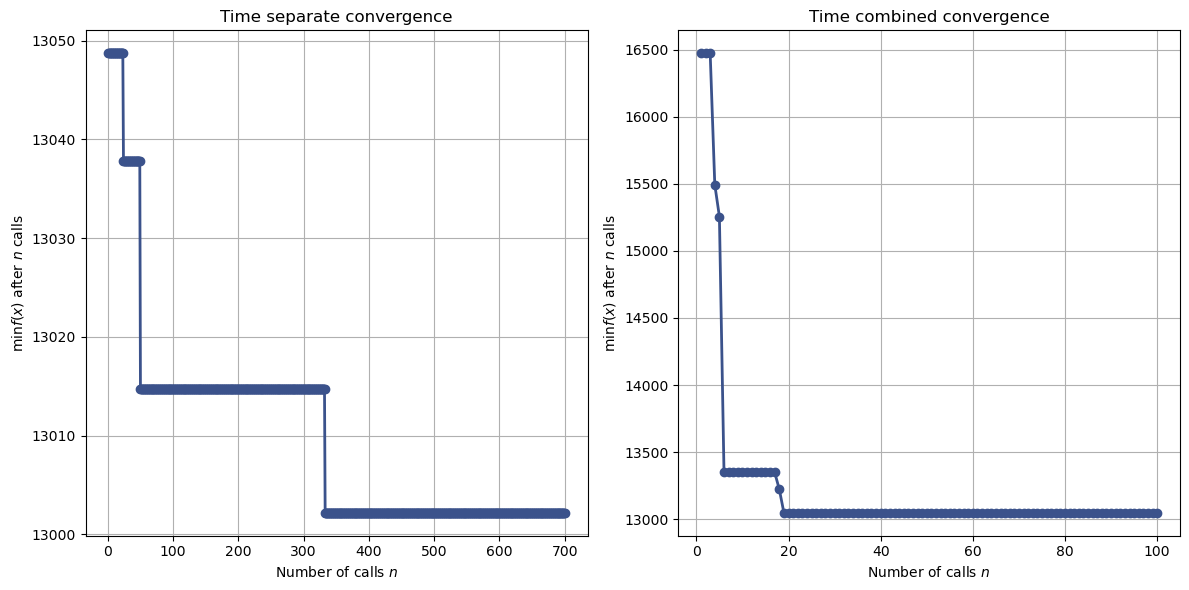

In [9]:
time_separate = load('model_fitting/time_separate_optimize.pkl')
time_combined = load('model_fitting/time_combined_optimize.pkl')

separate_bic = calculate_BIC(time_separate.fun, time_pressure_data, free_params=3)
combined_bic = calculate_BIC(time_combined.fun, time_pressure_data, free_params=2)

print("Time separate")
print("Delay Iters: ", time_separate.x[0], "| Pressure Iters: ", time_separate.x[1], "| Beta: ", 0.23, "| NLL: ", np.round(time_separate.fun,2),  "| BIC: ", np.round(separate_bic,2))
print("Time combined")
print("Iters: ", time_combined.x[1], "| Beta: ", np.round(time_combined.x[0],2), "| NLL: ", np.round(time_combined.fun,2), "| BIC: ", np.round(combined_bic,2))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_convergence(time_separate, ax=ax[0])
ax[0].set_title('Time separate convergence')

plot_convergence(time_combined, ax=ax[1])
ax[1].set_title('Time combined convergence')

plt.tight_layout()
plt.show()

In [69]:
time_delay = time_pressure_data[time_pressure_data['timed'] == 0]
time_pressure = time_pressure_data[time_pressure_data['timed'] == 1]

time_delay_dual = gp_minimize(lambda x: calculate_NLL_stochastic(x, model="dual",data=time_delay),                  # the function to minimize
                  [(0.1, 1), (0,5000)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=100,         # the number of evaluations of f
                  n_initial_points=10,  # the number of random initialization points
                  random_state=1234,   # the random seed
                  verbose=True)   
time_delay_dual.specs['args']['func'] = None
dump(time_delay_dual, 'model_fitting/time_delay_dual_optimize.pkl')

time_pressure_dual = gp_minimize(lambda x: calculate_NLL_stochastic(x, model="dual",data=time_pressure),                  # the function to minimize
                  [(0.1, 1), (0,5000)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=100,         # the number of evaluations of f
                  n_initial_points=10,  # the number of random initialization points
                  random_state=1234,   # the random seed
                  verbose=True)   
time_pressure_dual.specs['args']['func'] = None
dump(time_pressure_dual, 'model_fitting/time_pressure_dual_optimize.pkl')

Iteration No: 1 started. Evaluating function at random point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 96.7342
Function value obtained: 8004.7413
Current minimum: 8004.7413
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 58.6499
Function value obtained: 8235.2295
Current minimum: 8004.7413
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 19.2915
Function value obtained: 8596.4725
Current minimum: 8004.7413
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 67.1673
Function value obtained: 7268.8369
Current minimum: 7268.8369
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.5336
Function value obtained: 7208.2968
Current minimum: 7208.2968
Iteration No: 6 started. Evaluating function at random point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 64.0644
Function value obtained: 7116.4211
Current minimum: 7116.4211
Iteration No: 12 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 64.0481
Function value obtained: 7135.3317
Current minimum: 7116.4211
Iteration No: 13 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 63.1887
Function value obtained: 7130.3878
Current minimum: 7116.4211
Iteration No: 14 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 63.3333
Function value obtained: 8724.2741
Current minimum: 7116.4211
Iteration No: 15 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 63.7639
Function value obtained: 7144.5620
Current minimum: 7116.4211
Iteration No: 16 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 4.8951
Function value obtained: 8150.5644
Current minimum: 7116.4211
Iteration No: 17 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 10.4009
Function value obtained: 7676.4145
Current minimum: 7116.4211
Iteration No: 18 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 62.2624
Function value obtained: 7160.0407
Current minimum: 7116.4211
Iteration No: 19 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 11.3803
Function value obtained: 7543.7060
Current minimum: 7116.4211
Iteration No: 20 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 13.4015
Function value obtained: 7271.8013
Current minimum: 7116.4211
Iteration No: 21 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 51.4217
Function value obtained: 7728.4114
Current minimum: 7116.4211
Iteration No: 22 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 13.3844
Function value obtained: 7365.3905
Current minimum: 7116.4211
Iteration No: 23 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 55.1342
Function value obtained: 7109.6275
Current minimum: 7109.6275
Iteration No: 24 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 56.9259
Function value obtained: 7147.2296
Current minimum: 7109.6275
Iteration No: 25 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 56.8063
Function value obtained: 7297.2075
Current minimum: 7109.6275
Iteration No: 26 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 60.1490
Function value obtained: 7754.3957
Current minimum: 7109.6275
Iteration No: 27 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 56.2985
Function value obtained: 7780.1902
Current minimum: 7109.6275
Iteration No: 28 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 63.7512
Function value obtained: 7192.7562
Current minimum: 7109.6275
Iteration No: 29 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 63.6209
Function value obtained: 7189.6942
Current minimum: 7109.6275
Iteration No: 30 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 63.6044
Function value obtained: 7716.4556
Current minimum: 7109.6275
Iteration No: 31 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 61.8835
Function value obtained: 7170.8268
Current minimum: 7109.6275
Iteration No: 32 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 10.9471
Function value obtained: 7198.1988
Current minimum: 7109.6275
Iteration No: 33 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 18.8138
Function value obtained: 7141.0460
Current minimum: 7109.6275
Iteration No: 34 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 22.7928
Function value obtained: 7714.9842
Current minimum: 7109.6275
Iteration No: 35 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 16.4536
Function value obtained: 7094.1041
Current minimum: 7094.1041
Iteration No: 36 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 35.9371
Function value obtained: 8720.0772
Current minimum: 7094.1041
Iteration No: 37 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 55.4018
Function value obtained: 7155.4252
Current minimum: 7094.1041
Iteration No: 38 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 56.0898
Function value obtained: 7159.8467
Current minimum: 7094.1041
Iteration No: 39 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 55.6758
Function value obtained: 7160.4676
Current minimum: 7094.1041
Iteration No: 40 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 10.2270
Function value obtained: 7386.4715
Current minimum: 7094.1041
Iteration No: 41 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 14.8860
Function value obtained: 7121.3593
Current minimum: 7094.1041
Iteration No: 42 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 55.0194
Function value obtained: 7142.3755
Current minimum: 7094.1041
Iteration No: 43 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 30.2011
Function value obtained: 7673.5613
Current minimum: 7094.1041
Iteration No: 44 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 38.0775
Function value obtained: 7151.1422
Current minimum: 7094.1041
Iteration No: 45 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 36.5704
Function value obtained: 7702.4207
Current minimum: 7094.1041
Iteration No: 46 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 54.9624
Function value obtained: 7148.0971
Current minimum: 7094.1041
Iteration No: 47 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 38.1995
Function value obtained: 7423.2515
Current minimum: 7094.1041
Iteration No: 48 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 41.1498
Function value obtained: 7162.3030
Current minimum: 7094.1041
Iteration No: 49 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 54.6278
Function value obtained: 7952.5517
Current minimum: 7094.1041
Iteration No: 50 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 23.0573
Function value obtained: 8135.4216
Current minimum: 7094.1041
Iteration No: 51 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 55.9569
Function value obtained: 7128.4478
Current minimum: 7094.1041
Iteration No: 52 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 32.8094
Function value obtained: 7215.9387
Current minimum: 7094.1041
Iteration No: 53 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 25.5648
Function value obtained: 7216.3468
Current minimum: 7094.1041
Iteration No: 54 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 19.9583
Function value obtained: 7181.2961
Current minimum: 7094.1041
Iteration No: 55 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 49.6330
Function value obtained: 7122.3618
Current minimum: 7094.1041
Iteration No: 56 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 23.8146
Function value obtained: 7418.4796
Current minimum: 7094.1041
Iteration No: 57 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 16.7709
Function value obtained: 7176.8127
Current minimum: 7094.1041
Iteration No: 58 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 28.8043
Function value obtained: 7157.7180
Current minimum: 7094.1041
Iteration No: 59 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 4.4499
Function value obtained: 8389.5483
Current minimum: 7094.1041
Iteration No: 60 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 25.4401
Function value obtained: 7130.2037
Current minimum: 7094.1041
Iteration No: 61 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 13.6914
Function value obtained: 7193.9127
Current minimum: 7094.1041
Iteration No: 62 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 55.3787
Function value obtained: 7134.3428
Current minimum: 7094.1041
Iteration No: 63 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 55.9402
Function value obtained: 8378.3754
Current minimum: 7094.1041
Iteration No: 64 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 55.4075
Function value obtained: 7154.8827
Current minimum: 7094.1041
Iteration No: 65 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 55.4002
Function value obtained: 7142.9202
Current minimum: 7094.1041
Iteration No: 66 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 13.6403
Function value obtained: 7868.3296
Current minimum: 7094.1041
Iteration No: 67 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 39.9824
Function value obtained: 8264.3088
Current minimum: 7094.1041
Iteration No: 68 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 21.4678
Function value obtained: 7140.6025
Current minimum: 7094.1041
Iteration No: 69 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 15.8507
Function value obtained: 7118.3956
Current minimum: 7094.1041
Iteration No: 70 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 3.8060
Function value obtained: 8054.1212
Current minimum: 7094.1041
Iteration No: 71 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 60.2430
Function value obtained: 7131.9511
Current minimum: 7094.1041
Iteration No: 72 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 39.0198
Function value obtained: 7119.8849
Current minimum: 7094.1041
Iteration No: 73 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 46.4910
Function value obtained: 7103.3384
Current minimum: 7094.1041
Iteration No: 74 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 29.9935
Function value obtained: 7118.5119
Current minimum: 7094.1041
Iteration No: 75 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 165.9851
Function value obtained: 7535.0788
Current minimum: 7094.1041
Iteration No: 76 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 80.3609
Function value obtained: 8731.0306
Current minimum: 7094.1041
Iteration No: 77 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 77.5936
Function value obtained: 7144.7074
Current minimum: 7094.1041
Iteration No: 78 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 94.7574
Function value obtained: 7144.9383
Current minimum: 7094.1041
Iteration No: 79 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 33.2174
Function value obtained: 7080.8756
Current minimum: 7080.8756
Iteration No: 80 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 24.5577
Function value obtained: 7159.2118
Current minimum: 7080.8756
Iteration No: 81 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 63.4249
Function value obtained: 7851.4643
Current minimum: 7080.8756
Iteration No: 82 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 94.6551
Function value obtained: 7105.2429
Current minimum: 7080.8756
Iteration No: 83 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 20.1964
Function value obtained: 7117.0009
Current minimum: 7080.8756
Iteration No: 84 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 94.9643
Function value obtained: 7128.3746
Current minimum: 7080.8756
Iteration No: 85 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 33.6691
Function value obtained: 7128.8105
Current minimum: 7080.8756
Iteration No: 86 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 45.3918
Function value obtained: 7127.3201
Current minimum: 7080.8756
Iteration No: 87 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 17.4217
Function value obtained: 7096.4121
Current minimum: 7080.8756
Iteration No: 88 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 32.4630
Function value obtained: 7135.3929
Current minimum: 7080.8756
Iteration No: 89 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 51.7271
Function value obtained: 7111.2445
Current minimum: 7080.8756
Iteration No: 90 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 121.7372
Function value obtained: 7161.4740
Current minimum: 7080.8756
Iteration No: 91 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 25.1960
Function value obtained: 7107.4890
Current minimum: 7080.8756
Iteration No: 92 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 71.5898
Function value obtained: 7121.8384
Current minimum: 7080.8756
Iteration No: 93 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 21.3885
Function value obtained: 8731.0962
Current minimum: 7080.8756
Iteration No: 94 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 29.8482
Function value obtained: 7149.5856
Current minimum: 7080.8756
Iteration No: 95 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 24.5208
Function value obtained: 7124.3804
Current minimum: 7080.8756
Iteration No: 96 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 47.2071
Function value obtained: 7147.2983
Current minimum: 7080.8756
Iteration No: 97 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 17.5910
Function value obtained: 7125.0605
Current minimum: 7080.8756
Iteration No: 98 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 30.4869
Function value obtained: 7119.2011
Current minimum: 7080.8756
Iteration No: 99 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 21.8636
Function value obtained: 7121.5244
Current minimum: 7080.8756
Iteration No: 100 started. Searching for the next optimal point.


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_1113/3668836295.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 25.9930
Function value obtained: 7130.5327
Current minimum: 7080.8756


PicklingError: Can't pickle <function <lambda> at 0x14c8bfb00>: it's not found as __main__.<lambda>

In [2]:
time_delay = load('time_delay_dual_optimize.pkl')
time_pressure = load('time_pressure_dual_optimize.pkl')

print("Time delay")
print("Iters: ", time_delay.x[1], "| Beta: ", np.round(time_delay.x[0],2), "| NLL: ", np.round(time_delay.fun,2))
print("Time pressure")
print("Iters: ", time_pressure.x[1], "| Beta: ", np.round(time_pressure.x[0],2), "| NLL: ", np.round(time_pressure.fun,2))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_convergence(time_delay, ax=ax[0])
ax[0].set_title('Time delay convergence')

plot_convergence(time_pressure, ax=ax[1])
ax[1].set_title('Time pressure convergence')

plt.tight_layout()
plt.show()

NameError: name 'load' is not defined

In [37]:
from multiprocess import Pool
ITERS = [100, 200, 300]
repeats = 4

def calculate_average_NLL(model, iters, data):
    nll = []
    for iter in iters:
        with Pool() as pool:
            nll_runs = pool.map(lambda _: calculate_NLL(model, iter, insight_data), range(repeats))
        print(np.mean(nll_runs), nll_runs)
        nll += [np.mean(nll_runs)]
    return nll

mc_nll = calculate_average_NLL("MC", ITERS, insight_data) 
print(mc_nll)
dual_nll = calculate_average_NLL("dual", ITERS, insight_data)
print(dual_nll)
nn_nll = calculate_NLL('NN', 0, insight_data)
print(nn_nll)

95132.98736475845 [95132.98736475845, 95132.98736475845, 95132.98736475845, 95132.98736475845]
94327.22812021631 [94327.22812021631, 94327.22812021631, 94327.22812021631, 94327.22812021631]
90779.63523475744 [90779.63523475744, 90779.63523475744, 90779.63523475744, 90779.63523475744]
[95132.98736475845, 94327.22812021631, 90779.63523475744]
neural net loadedneural net loadedneural net loaded


neural net loaded
76869.19371648801 [76869.19371648801, 76869.19371648801, 76869.19371648801, 76869.19371648801]
neural net loadedneural net loadedneural net loadedneural net loaded



75473.80156288529 [75473.80156288529, 75473.80156288529, 75473.80156288529, 75473.80156288529]
neural net loadedneural net loadedneural net loadedneural net loaded



75234.08111056856 [75234.08111056856, 75234.08111056856, 75234.08111056856, 75234.08111056856]
[76869.19371648801, 75473.80156288529, 75234.08111056856]
neural net loaded
78797.89812364028


In [38]:
nll_mc1000 = calculate_NLL('MC', 1000, insight_data)

In [41]:
time_delay = time_pressure_data[time_pressure_data['timed'] == 0]
time_pressure = time_pressure_data[time_pressure_data['timed'] == 1]
nll_dualdelay = calculate_BIC('dual', 100, time_delay)
nll_nndelay = calculate_BIC('NN', 0, time_delay)
nll_dualpressure = calculate_BIC('dual', 100, time_pressure)
nll_nnpressure = calculate_BIC('NN', 0, time_pressure)

neural net loaded


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_16098/2031913416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


neural net loaded


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_16098/2031913416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


neural net loaded


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_16098/2031913416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


neural net loaded


/var/folders/6y/gzz1g_p559n80dc3_f2fl6m80000gn/T/ipykernel_16098/2031913416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[model + "_Q"] = data.apply(lambda x: Q_dict[x.gridnum][x.transformed_state], axis=1)


In [42]:
print("model fits under time delay: ")
print("NN: ", nll_nndelay, ", dual: ", nll_dualdelay)
print("model fits under time pressure: ")
print("NN: ", nll_nnpressure, ", dual: ", nll_dualpressure)

model fits under time delay: 
NN:  47535.9265049618 , dual:  45155.72692610109
model fits under time pressure: 
NN:  37339.21171737829 , dual:  37334.46276200564


In [158]:
data = insight_data #insight_data[(insight_data['gridnum']<=208) & (insight_data['gridnum']>=101)]
mc = minimize_scalar(lambda beta: neg_log_likelihood(beta, data, 'MC'),bounds=(0.01, 10), method='bounded')
nn = minimize_scalar(lambda beta: neg_log_likelihood(beta, data, 'NN'),bounds=(0.01, 10), method='bounded')
dual = minimize_scalar(lambda beta: neg_log_likelihood(beta, data, 'dual'),bounds=(0.01, 10), method='bounded')

mc_nll = neg_log_likelihood(mc.x, data, 'MC')
nn_nll = neg_log_likelihood(nn.x, data, 'NN')
dual_nll = neg_log_likelihood(dual.x, data, 'dual')

print("MC beta: ", mc.x, "MC NLL: ", mc_nll)
print("NN beta: ", nn.x, "NN NLL: ", nn_nll)
print("Dual beta: ", dual.x, "Dual NLL: ", dual_nll)

MC beta:  0.895068768407847 MC NLL:  99007.51670779652
NN beta:  0.29526529859323564 NN NLL:  78797.89812364028
Dual beta:  0.21289758604386932 Dual NLL:  77794.25258437687


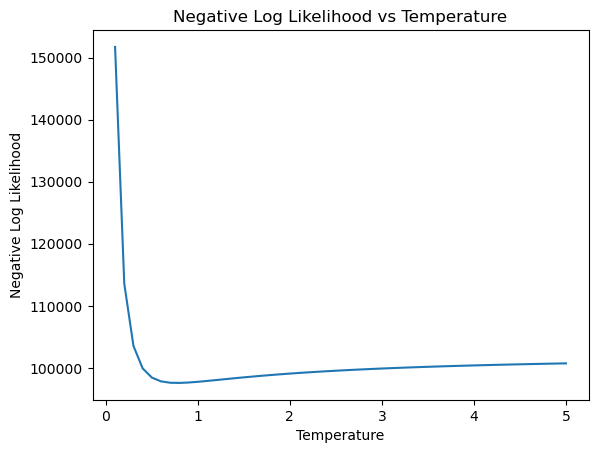

In [142]:
import matplotlib.pyplot as plt

temperatures = np.linspace(0.1, 5, 50)
nll_values = [neg_log_likelihood(temp, data, 'MC') for temp in temperatures]

plt.plot(temperatures, nll_values)
plt.xlabel('Temperature')
plt.ylabel('Negative Log Likelihood')
plt.title('Negative Log Likelihood vs Temperature')
plt.show()

MC beta:  0.7707871244153109 MC NLL:  97558.15379185592
NN beta:  0.29526529859323564 NN NLL:  78797.89812364028
Dual beta:  0.18734479803382798 Dual NLL:  75546.44079410128
